In [1]:
1

1

In [2]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import uproot
import uproot3
import R2h_module as r2h
import root_pandas as rpd
from root_pandas import read_root
from matplotlib import rc
import seaborn as sns
import cupy as cp, math, pylab
import os, os.path
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 13}) 
mpl.rcParams.update({'ytick.labelsize': 13}) 
mpl.rcParams.update({'text.usetex' : False})
rc('font', weight='bold')
colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'


plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

Welcome to JupyROOT 6.27/01


/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


**Definition of some constants**

In [3]:
# defining the edges and number of bins for each variable.
dpionMassBins=11
maxzmass=1.7
minzmass=0.3

dpiondphiBins=9
maxdphi=3.14
mindphi=0.0

dpionz2Bins=9
maxz2=0.45
minz2=0.05

## systematic errors for the 3 different variables
#sysErr_z2   = np.array([3.32080926,2.756116784,2.562141684,2.909661135,3.212331314,3.872142459,5.208199077,5.151592545])
#sysErr_dphi = np.array([3.829435252,3.354814974,2.230653814,1.943792247,2.008438408,2.288362377,2.915745401,4.527098216 ])
#sysErr_mass = np.array([2.879452899,2.879452899,2.879452899,2.879452899,2.879452899,3.041586593,3.245188592,3.482994258,3.748499566,4.03624194 ])

sysErr_z2 = {}
sysErr_z2['C'] = np.array([3.692202419,
    3.212142566,
    2.570701518,
    2.596996206,
    2.673649758,
    2.912079542,
    3.608299589,
    4.204192233])
sysErr_z2['Fe'] =sysErr_z2['C']
sysErr_z2['Pb'] = sysErr_z2['C']

sysErr_dphi = {}
sysErr_dphi['C'] =np.array([4.25648903,3.156250443,2.614883064,2.523107341,
                             2.533560227,2.547747002,2.62759471,3.001707032])
sysErr_dphi['Fe'] = sysErr_dphi['C']
sysErr_dphi['Pb'] = sysErr_z2['C']

sysErr_mass = {}
sysErr_mass['C'] = np.array([3.409193127,
    4.79263029,
    2.541211342,
    2.610459367,
    2.727169307,
    2.746379935,
    3.119634527,
    3.874351389,
    4.828794128,
    6.764388662])
sysErr_mass['Fe'] = sysErr_mass['C']
sysErr_mass['Pb'] = np.array([3.587840267,
    4.79263029,
    2.541211342,
    2.610459367,
    2.727169307,
    2.746379935,
    3.119634527,
    3.874351389,
    5.684826535,
    8.588186885])


#outdir='/home/seba/di-hadron/resultsPlots_images/'
outdir='/home/sebouh/di-hadron-paper/plots/'


# Get data from Ntuples to dataframes

In [4]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

# Getting Data

In [5]:
%%time
df = {}
df_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.03 s, sys: 364 ms, total: 4.4 s
Wall time: 4.39 s


In [6]:
print(df['C'].columns)

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCut', 'h2_FidCut', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt'],
      dtype='object')


In [7]:
#df['C'].hist(figsize=(12,12),bins=100,column=['nu','t','Q2','h2_pid', 'h1_pid','h1_xf', 'h2_xf'])
#plt.show()

# Getting GiBUU

In [8]:
%%time

pathGIBUU="/home/miguel/eg2dihadron/"
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print (target)
    print (' trigger')
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), 
                                                           '%s_trigger'%target)
    print (' pairs')
    df['GiBUU_%s'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), target)
print (df_trigger.keys())

D
 trigger
 pairs
C
 trigger
 pairs
Fe
 trigger
 pairs
Pb
 trigger
 pairs
dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'GiBUU_D_trigger', 'GiBUU_C_trigger', 'GiBUU_Fe_trigger', 'GiBUU_Pb_trigger'])
CPU times: user 14.6 s, sys: 770 ms, total: 15.4 s
Wall time: 15.3 s


In [9]:
print (df_trigger['GiBUU_C_trigger'].keys())
print (df_trigger['GiBUU_C_trigger'].shape[0])
#df['GiBUU_Fe'].eval('Xb=Q2/(2*0.938272*nu)', inplace=True)
#df['GiBUU_Fe'].hist(figsize=(12,12),bins=100,column=['Xb','nu','W','Q2','h2_pid', 'h1_pid','h1_z', 'h2_th'])
#plt.show()

Index(['h1_pid', 'h1_xf', 'h1_z', 'h1_rap', 'ycm', 'h1_pt', 'Q2', 'x', 'nu',
       'W', 'h1_cm_ph', 'h1_cm_th', 'mass', 'pstar', 'plstar', 'eta',
       'TargType', 'h1_ph', 'h1_th', 'pos_x', 'pos_y', 'pos_z', '__index__'],
      dtype='object')
2011729


# Combine the D2 data-sets

In [10]:
#df['D'] = df['D_Fe']
#df_trigger['D_trigger'] = df_trigger['D_Fe_trigger']
 #df['D'] = pd.concat([df['D_Fe']) #simply combine the deuterium results for all targets
#df_trigger['D_trigger'] = pd.concat([df_trigger['D_Fe_trigger']]) #simply combine the deuterium results for all targets

#print (df.keys())
#print(df['Fe'].keys())
#print(df_trigger['Fe_trigger'].keys())
## this is just to notice that there are no vectors in the variables, all of them are numbers
#print(df['Fe'].describe())
#print('there are ',len(df['Fe']), 'entries')

watching some distributions

In [11]:
#df['Fe'].hist(figsize=(12,12),bins=100,column=['dphi','dphi_lab','h2_cm_th','h2_pid'])
#plt.show()

# Apply selection to datasets
**Here are applied the cuts for GiBUU**

In [12]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df[key] = r2h.applyCuts(df[key],isMC=isMC, nomCuts=True)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC, nomCuts=True)


key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
0.2<h1_p<5.0  131585  (100.00  %)
inelasticity < 0.85 131585  (100.00  %)
h1_pid = pions (trigger) 131585  (100.00  %)
2.2 < nu <4.2 129258  (98.23  %)
25 degree separation between pion and electron.  This is a dumb cut 129258  (100.00  %)
10< h1_th 129258  (100.00  %)
Theta/P fiducial region selected for trigger hadron 129258  (100.00  %)
Nom cuts for the trigger applied 44785  (34.65  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44785  (100.00  %)
2.2 < nu < 4.2 44785  (100.00  %)
secondary hadrons are pions 44785  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 35717  (79.75  %)
kinematic limits for h2_z 35636  (99.77  %)
kinematic limits for dphi 35596  (99.89  %)
kinematic limits for pair_mass 35415  (99.49  %)
leading hadrons are pions 35415  (100.00  %)
0.2<h2_p<5.0 35415  (100.00  %)
0.2<h1_p<5.0 35415  (100.00  %)
25 degree separation between pion and electron.  This is a dumb 

0.2<h2_p<5.0 998503  (90.58  %)
0.2<h1_p<5.0 998503  (100.00  %)

key:  GiBUU_C
Entries before cut  2226123
Q2>1.0 and Q2<4.0 2225228  (99.96  %)
0.2<h1_p<5.0  2225228  (100.00  %)
inelasticity < 0.85 2225228  (100.00  %)
h1_pid = pions (trigger) 2225228  (100.00  %)
2.2 < nu <4.2 2125385  (95.51  %)
Starting election on dipion variables
This is MC
1.0< Q2 <4.0 2125385  (100.00  %)
2.2 < nu < 4.2 2125385  (100.00  %)
secondary hadrons are pions 1198467  (56.39  %)
(h1_pid*h2_pid)<0, opposite charge pions 1091014  (91.03  %)
kinematic limits for h2_z 1035451  (94.91  %)
kinematic limits for dphi 1034440  (99.90  %)
kinematic limits for pair_mass 1026890  (99.27  %)
leading hadrons are pions 1026890  (100.00  %)
0.2<h2_p<5.0 888419  (86.52  %)
0.2<h1_p<5.0 888419  (100.00  %)

key:  GiBUU_Fe
Entries before cut  1014645
Q2>1.0 and Q2<4.0 1014170  (99.95  %)
0.2<h1_p<5.0  1014170  (100.00  %)
inelasticity < 0.85 1014170  (100.00  %)
h1_pid = pions (trigger) 1014170  (100.00  %)
2.2 < nu <4

In [13]:
for key in df_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    df_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    
    

C_trigger False
Entries before cut  652690
Q2>1.0 and Q2<4.0 652690  (100.00  %)
0.2<h1_p<5.0  652674  (100.00  %)
inelasticity < 0.85 652674  (100.00  %)
h1_pid = pions (trigger) 652674  (100.00  %)
2.2 < nu <4.2 642836  (98.49  %)
25 degree separation between pion and electron.  This is a dumb cut 642836  (100.00  %)
10< h1_th 642836  (100.00  %)
Theta/P fiducial region selected for trigger hadron 642836  (100.00  %)
Nom cuts for the trigger applied 291788  (45.39  %)
 
D_C_trigger False
Entries before cut  875478
Q2>1.0 and Q2<4.0 875478  (100.00  %)
0.2<h1_p<5.0  875467  (100.00  %)
inelasticity < 0.85 875467  (100.00  %)
h1_pid = pions (trigger) 875467  (100.00  %)
2.2 < nu <4.2 863117  (98.59  %)
25 degree separation between pion and electron.  This is a dumb cut 863117  (100.00  %)
10< h1_th 863117  (100.00  %)
Theta/P fiducial region selected for trigger hadron 863117  (100.00  %)
Nom cuts for the trigger applied 405810  (47.02  %)
 
Fe_trigger False
Entries before cut  370123



# R_2h data from HERMES and Neutrino buble-chamber experiment

In [14]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.004)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.004)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))

neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)





In [22]:
p_thr=2.7
Nphe_thr=5
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)

pair_cut_nom  ='and h1_th<90 and h1_th>10 and h2_th<90 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxzmass ,minzmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and h1_th<90 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

pair_cut_nom  ='and h1_th>10 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and pair_mass<%s and pair_mass>%s and (h1_z+h2_z)<1.0 and (h1_pid*h2_pid)<0.  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2,maxzmass ,minzmass, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)




In [16]:
 #df_trigger['GiBUU_C_trigger'].query('h1_z>0.5').shape[0]
type(df_trigger['GiBUU_C_trigger'])    

pandas.core.frame.DataFrame

In [24]:
import imp
imp.reload(mpl)
import mplhep as hep
hep.set_style("CMS")

symbols={"C":"o","Fe":"s", "Pb": "v"}
linestyles={"C":"-", "Fe":"--","Pb":"-."}

<ipython-input-24-a3c0765a56f6>:4: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("CMS")


Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not 

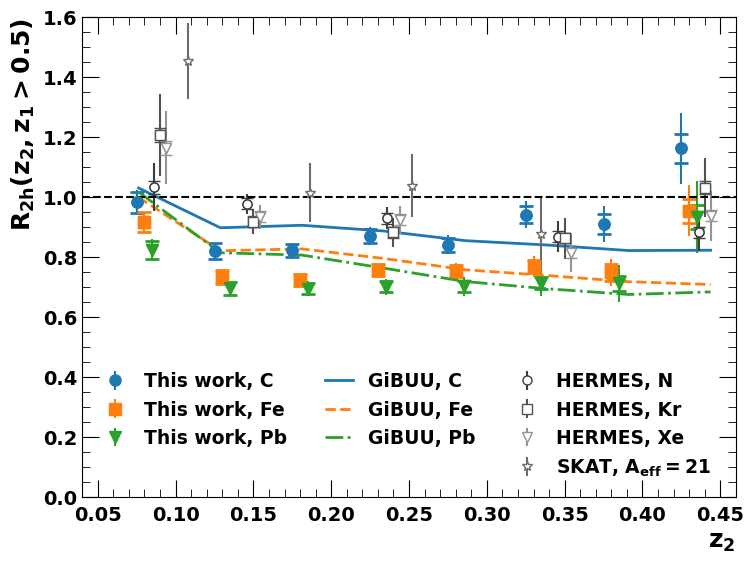

In [56]:
fig = plt.figure(figsize=(8,6))
colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_z2

artists=[]

z2Table={}

dummy = plt.plot([],[], label=' ', alpha=0)[0]

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=minz2,maxz=maxz2, nbins=dpionz2Bins, variable='h2_z', 
                        pair_cut = pair_cut_nom,trig_cut = trigger_cut_nom)
    
    z2Table[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":minz2,"max":maxz2,"bins":dpionz2Bins} 
    stat=err
    syst=r*(sysErr[target]/100)
    tot=np.hypot(stat,syst)
    artists.append(plt.errorbar(x+0.005*i,r,yerr=tot,label='This work, %s'%target,fmt=symbols[target],ms=8,color=colorBands[i+1])) ## 'fmt' is for formatting
    plt.errorbar(x+0.005*i,r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[i+1])
    #if i==0:plt.fill_between(x+0.005, 0,sysErr/100., color=colorBands[i],alpha=0.4)
    print(err)
    print(sysErr[target]/100)
artists.append(dummy)
for i,target in enumerate(['C','Fe','Pb']):    
    #plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',
    #alpha=0.99,color=colors[target])
    #plt.fill_between(np.subtract(x, 0,1.04, color=colors[target],alpha=0.2)
    #GiBUU
    print('GiBUU: ', target)
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=minz2,maxz=maxz2+0.02, nbins=dpionz2Bins, applyweight=False, 
                        pair_cut = '')
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU, %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])
    #plt.errorbar(x,r,yerr=0,label='GiBUU, %s'%target,fmt='o', ls='-', lw=3, alpha=0.7, ms=0.)
    #plt.fill_between(x+0.00*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.7,lw=1,color=colorBands[i+1])
    artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0]) 
plt.xlabel('$\mathrm{z}_{\mathrm{2}}$',fontsize=18, fontweight='bold')
plt.ylabel('$\mathrm{R}_{\mathrm{2h}}(\mathrm{z}_2,\mathrm{z}_1>0.5)$',fontsize=18, fontweight='bold')
artists.append(dummy)


# artists.append(plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',
#              label='HERMES, N',fillstyle=None,ms=8, color='darkred'))
# artists.append(plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='s',mfc='white',
#              label='HERMES, Kr',fillstyle=None,ms=8, color='mediumpurple'))
# artists.append(plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='v',mfc='white',
#              label='HERMES, Xe',fillstyle=None,ms=8, color='peru'))

#other_colors={"N":"#524444", "Kr": "#575745", "Xe":"#888899", "A": "#827082"}


other_colors={"N":"0.24", "Kr": "0.32", "Xe":"0.58", "A": "0.42"}

#other_colors={"N":"0.3", "Kr": "0.3", "Xe":"0.3", "A": "0.5"}
#other_colors={"N":"0.5", "Kr": "0.5", "Xe":"0.5", "A": "0.3"}


artists.append(plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',
             label='HERMES, N',fillstyle=None,ms=6.5, color=other_colors['N']))
artists.append(plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='s',mfc='white',
             label='HERMES, Kr',fillstyle=None,ms=6.5, color=other_colors['Kr']))
artists.append(plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='v',mfc='white',
             label='HERMES, Xe',fillstyle=None,ms=6.5, color=other_colors['Xe']))

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ysyst['N'],fmt='o',mfc='white',
             capsize=4, fillstyle=None,ms=6.5, color=other_colors['N'])
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ysyst['Kr'],fmt='s',mfc='white',
             capsize=4, fillstyle=None,ms=6.5, color=other_colors['Kr'])
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ysyst['Xe'],fmt='v',mfc='white',
             capsize=4, fillstyle=None,ms=6.5, color=other_colors['Xe'])


#plt.text(0.10, 0.93,'a)',fontsize=20,
#     horizontalalignment='center',
#     verticalalignment='center',
#     transform = plt.gca().transAxes) 
artists.append(plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='*',mfc='white',
            label='SKAT, $A_{eff}=21$',fillstyle=None,ms=7,capsize=0, color=other_colors['A']))

plt.ylim([0.,1.6])
plt.xlim([0.04,0.46])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(artists, [artist.get_label() for artist in artists],loc='best',fontsize=13.5,ncol=3 )

plt.tight_layout()
##plt.savefig('ComparisonWithHermes_Linear.png')
#plt.ylim([0.55,1.85]) 

#plt.yscale('log')
##plt.savefig('ComparisonWithHermes_Log.png')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.xticks(np.arange(0.05,0.5,0.05),fontsize=14)
plt.yticks(fontsize=14)

outname="z2"
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
#for paper
del colorBands
plt.show()

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not 

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.05 and h2_z<0.45
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_z>0.05 and h2_z<0.45


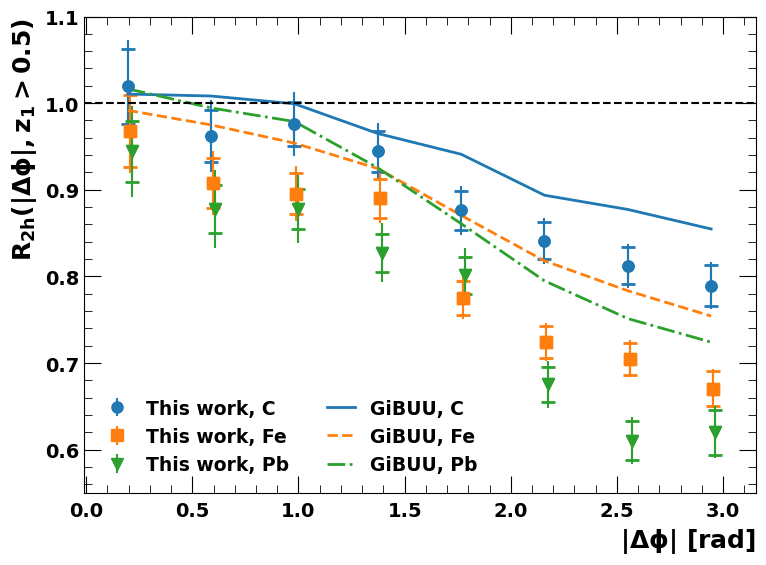

In [19]:
fig = plt.figure(figsize=(8,6))

dphiTable={}

artists=[]

colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                            pair_cut = '%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                            trig_cut = '%s'%trigger_cut_nom)
                            #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                            #trig_cut = 'h1_z>0.5' 
    dphiTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
    print('x is: ', x)
    print('r is: ', r) 
    print('err is: ', err) 
    print('sys err is:', sysErr[target]/100)
    stat=err
    syst=r*(sysErr[target]/100)
    tot=np.hypot(stat,syst)
    artists.append(plt.errorbar(np.subtract(x,-j*0.009),r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],
                 alpha=0.99,color=colors[target],)) #capsize=5, capthick=2)
    plt.errorbar(np.subtract(x,-j*0.009),r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[j+1])
    
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
for j,target in enumerate(['C','Fe','Pb']):   
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                        pair_cut='and h2_z>0.05 and h2_z<0.45',
                           trig_cut='h1_z>0.5')
    artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])
    #plt.fill_between(x+0.005*j,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

#plt.text(0.10, 0.93,'c)',fontsize=20,
#     horizontalalignment='center',
#     verticalalignment='center',
#     transform = plt.gca().transAxes)    
    
plt.xlabel('$|\Delta\phi|$ [rad]',fontsize=18, fontweight='bold')
plt.ylabel('$\mathrm{R}_{\mathrm{2h}}(|\Delta\phi|,\mathrm{z}_1>0.5)$',fontsize=18, fontweight='bold')
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)

plt.xlim([-0.01,3.155])
plt.ylim([0.55,1.1])
#plt.ylim([0.55,0.73])
#plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(artists, [artist.get_label() for artist in artists],loc='lower left',fontsize=13.5,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

#for paper
outname='dphi'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
plt.show()


Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not

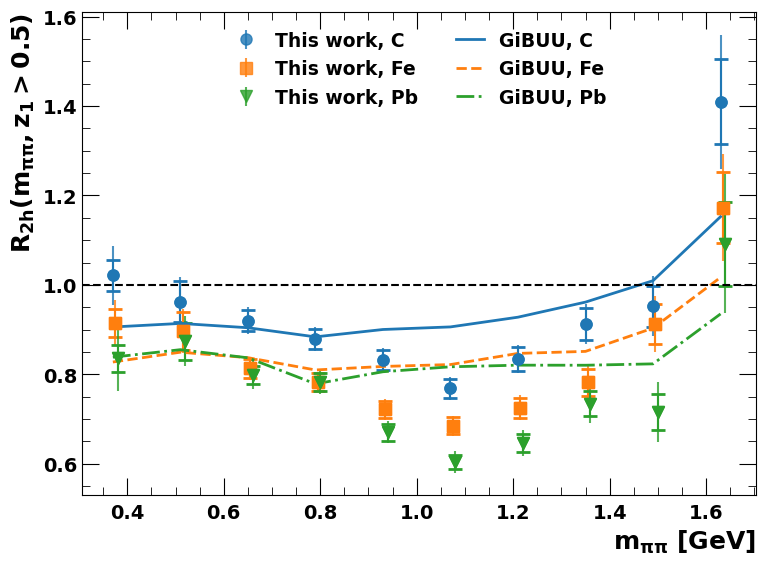

In [20]:
fig = plt.figure(figsize=(8,6))
colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_mass

massTable={}
artists=[]
for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], 
                        df_trigger['D_%s_trigger'%target],variable='pair_mass',
                            minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                            pair_cut='%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                            trig_cut = '%s '%trigger_cut_nom, applyweight=False)
    
    massTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":minzmass,"max":maxzmass,"bins":dpionMassBins} 
    
    stat=err
    syst=r*(sysErr[target]/100)
    tot=np.hypot(stat,syst)
    
    artists.append(plt.errorbar(x+0.005*i,r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],alpha=0.8,color=colors[target]))
    plt.errorbar(x+0.005*i,r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[i+1])

for i,target in enumerate(['C','Fe','Pb']):    
    #plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])
    
    ##GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger'],variable='pair_mass',
                            minz=minzmass,maxz=maxzmass,nbins=dpionMassBins,
                            pair_cut='and h2_z>0.05 and h2_z<0.45', trig_cut='h1_z>0.5',applyweight=False)
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    #plt.plot(x+0.005*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
    #plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])
    artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])

#plt.text(0.10, 0.93,'b)',fontsize=20,
#     horizontalalignment='center',
#     verticalalignment='center',
#     transform = plt.gca().transAxes)        
    
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)
plt.legend(artists, [artist.get_label() for artist in artists],ncol=2,loc='upper center',fontsize=13.5)
plt.xlabel('m$_{\pi\pi}$ [GeV]',fontsize=18,fontweight='bold' )
plt.ylabel('$\mathrm{R}_{\mathrm{2h}}(\\mathrm{m}_{\pi\pi},\\mathrm{z}_1>0.5)$',fontsize=18,fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')

plt.ylim([0.53,1.61])
#plt.plot([.77549]*2, 
#         [plt.gca().get_ylim()[0], plt.gca().get_ylim()[0]+.7*(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])],
#         color='r', linestyle=':')
#plt.text(.785, 1.2, "$\\rho^{0}$ mass", color='r', fontsize=14)
#plt.text(.77549, plt.gca().get_ylim()[0]-.1*(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0]), 
#         "$\\rho^{0}$", color='r', fontsize=14,horizontalalignment='center')




#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)
#plt.xscale('log')
#plt.ylim([0.0,1.2])
plt.tight_layout()
##plt.savefig('MainResult_withGiBUU_mass.png')

#for paper
outname='mass'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
plt.show()


{'C': 0    2.645751
1    2.645751
2    2.645751
3    2.645751
4    2.645751
5    2.645751
6    2.645751
7    2.645751
8    2.645751
9    2.645751
dtype: float64, 'Fe': 0    2.645751
1    2.645751
2    2.645751
3    2.645751
4    2.645751
5    2.645751
6    2.645751
7    2.645751
8    2.645751
9    2.645751
dtype: float64, 'Pb': 0    2.645751
1    2.645751
2    2.645751
3    2.645751
4    2.645751
5    2.645751
6    2.645751
7    2.645751
8    2.645751
9    2.645751
dtype: float64}
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h

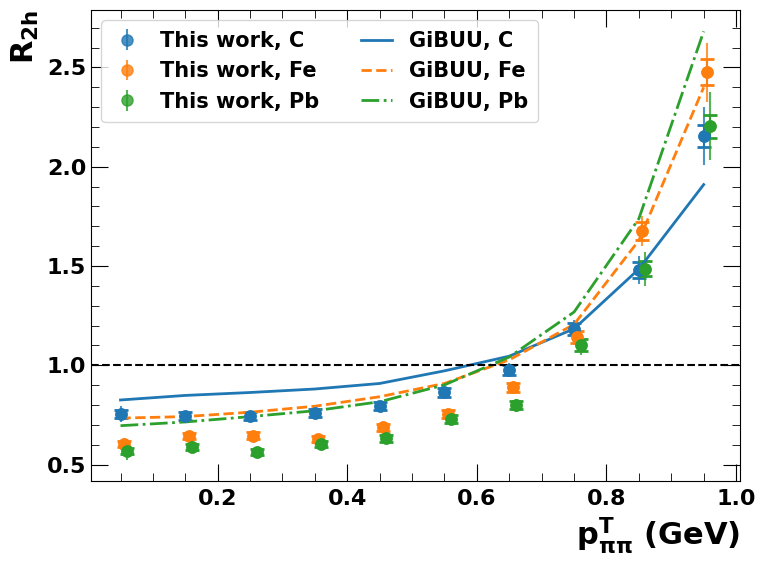

In [31]:
fig = plt.figure(figsize=(8,6))
colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']



ptTable={}
nbins=10
binningPt=dict(minz=0,maxz=1.0,nbins=nbins+1)

sysErr_pt = {a:pd.Series([np.sqrt(1+2**2+1+1) for i in range(nbins)]) for a in "C Fe Pb".split()}
print(sysErr_pt)
sysErr=sysErr_pt

artists=[]

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], 
                        df_trigger['D_%s_trigger'%target],variable='pair_pt',
                            **binningPt,
                            pair_cut='%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                            trig_cut = '%s '%trigger_cut_nom, applyweight=False)
    
    ptTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":minzmass,"max":maxzmass,"bins":dpionMassBins} 
    stat=err
    syst=r*(sysErr[target]/100)
    tot=np.hypot(stat,syst)
    artists.append(plt.errorbar(x+0.005*i,r,yerr=tot,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target]))
    plt.errorbar(x+0.005*i,r,yerr=syst,fmt='o',ms=8,capthick=2,capsize=5,color=colorBands[i+1])
    
    #plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])

for i,target in enumerate(['C','Fe','Pb']):    
    ##GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger'],variable='pair_pt',
                            **binningPt,
                            pair_cut='and h2_z>0.05 and h2_z<0.45', trig_cut='h1_z>0.5',applyweight=False)
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    #plt.plot(x+0.005*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
    #plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])
    artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0]) 
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(artists, [artist.get_label() for artist in artists],frameon=True,ncol=2,loc='upper left',fontsize=15)
plt.xlabel('$p^T_{\pi\pi}$ (GeV)',fontsize=22,fontweight='bold' )
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=22,fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)
#plt.xscale('log')
#plt.ylim([0.0,1.2])
plt.tight_layout()
##plt.savefig('MainResult_withGiBUU_mass.png')

#for paper
outname='pt'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
plt.show()

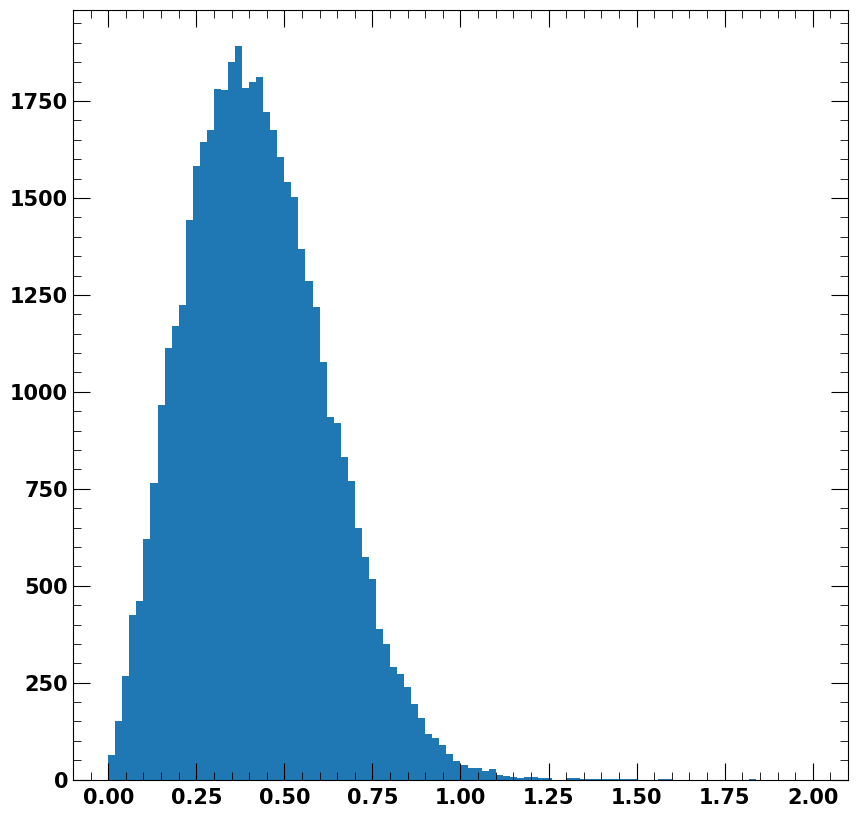

In [32]:
plt.hist(df["D_C"].pair_pt,bins=100, range=(0,2))
plt.show()

In [39]:
chi2=0
for table in z2Table, dphiTable, massTable:
    for i in range(table['Fe']['bins']-1):
        chi2+=(table['Fe']["r"][i]-table['Pb']["r"][i])**2/(table["Fe"]['drstat'][i]**2+table["Pb"]['drstat'][i]**2)
    dof = table['Fe']['bins']-2
    print(chi2, dof)
    from scipy.stats import chi2  as chi2lib
    print("p=",chi2lib.sf(chi2,dof))

31.459848145529413 7
p= 5.113225437774306e-05
74.48326377869061 7
p= 1.825958261088007e-13
116.12305606248403 9
p= 8.292291093522063e-21


In [40]:
x=[]
for table in z2Table, massTable, dphiTable:    
    for a in "C Fe Pb".split():
        x= x+list(np.divide(table[a]['drstat'],table[a]['r']))
print(max(x), np.median(x), min(x))
x=[]
for table in z2Table, massTable, dphiTable:    
    for a in "C Fe Pb".split():
        x= x+list(np.divide(table[a]['drstat'],table[a]['r'])/(table[a]['drsys']*.01)>1)
print(np.mean(x))


0.12013433487785204 0.026618163482852227 0.011380281892953623
0.3717948717948718


In [41]:
def printTable(table):
    for i in range(table[a]['bins']-1):
        mn= table[a]["min"]+i*(table["C"]["max"]-table["C"]["min"])/(table["C"]["bins"]-1)
        mx= table[a]["min"]+(i+1)*(table["C"]["max"]-table["C"]["min"])/(table["C"]["bins"]-1)
        print("%.2f--%.2f & "%(mn,mx)+" & ".join(["%.3f$\pm$%.3f$\pm$%.3f"%(table[a]["r"][i],table[a]['drstat'][i],\
                                                                table[a]["r"][i]*table[a]["drsys"][i]/100) \
                                      for a in "C Fe Pb".split()])+"\\\\")

In [42]:
print("$z_2$ & $R_{2h}$[C] & $R_{2h}$[Fe] & $R_{2h}$[Pb]\\\\")
printTable(z2Table)
print("$m_{\pi\pi}$ [GeV]& $R_{2h}$[C] & $R_{2h}$[Fe] & $R_{2h}$[Pb]\\\\")
printTable(massTable)
print("$|\Delta\phi|$ [rad]& $R_{2h}$[C] & $R_{2h}$[Fe] & $R_{2h}$[Pb]\\\\")
printTable(dphiTable)

$z_2$ & $R_{2h}$[C] & $R_{2h}$[Fe] & $R_{2h}$[Pb]\\
0.05--0.10 & 0.982$\pm$0.017$\pm$0.036 & 0.917$\pm$0.015$\pm$0.034 & 0.824$\pm$0.020$\pm$0.030\\
0.10--0.15 & 0.819$\pm$0.010$\pm$0.026 & 0.732$\pm$0.008$\pm$0.024 & 0.696$\pm$0.013$\pm$0.022\\
0.15--0.20 & 0.823$\pm$0.014$\pm$0.021 & 0.724$\pm$0.011$\pm$0.019 & 0.694$\pm$0.017$\pm$0.018\\
0.20--0.25 & 0.870$\pm$0.018$\pm$0.023 & 0.757$\pm$0.014$\pm$0.020 & 0.700$\pm$0.021$\pm$0.018\\
0.25--0.30 & 0.840$\pm$0.022$\pm$0.022 & 0.752$\pm$0.018$\pm$0.020 & 0.702$\pm$0.026$\pm$0.019\\
0.30--0.35 & 0.941$\pm$0.035$\pm$0.027 & 0.769$\pm$0.026$\pm$0.022 & 0.713$\pm$0.038$\pm$0.021\\
0.35--0.40 & 0.911$\pm$0.050$\pm$0.033 & 0.749$\pm$0.036$\pm$0.027 & 0.712$\pm$0.057$\pm$0.026\\
0.40--0.45 & 1.163$\pm$0.108$\pm$0.049 & 0.955$\pm$0.074$\pm$0.040 & 0.934$\pm$0.112$\pm$0.039\\
$m_{\pi\pi}$ [GeV]& $R_{2h}$[C] & $R_{2h}$[Fe] & $R_{2h}$[Pb]\\
0.30--0.44 & 1.021$\pm$0.057$\pm$0.035 & 0.914$\pm$0.041$\pm$0.031 & 0.836$\pm$0.066$\pm$0.030\\
0.44--0.58 

In [35]:
info = ""
for target in "C Fe Pb D_C D_Fe D_Pb".split():
    npair = len(df['%s'%target].query(trigger_cut_nom+ '%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom))
    ntrigger = len(df_trigger['%s_trigger'%target].query(trigger_cut_nom))
    info+= f"{target} & {ntrigger} & {npair} \\\\ \n"
    
print(info)

    

C & 291788 & 29218 \\ 
Fe & 370122 & 31944 \\ 
Pb & 123821 & 10120 \\ 
D_C & 405810 & 47003 \\ 
D_Fe & 667932 & 75126 \\ 
D_Pb & 630177 & 71430 \\ 



{'C': 0    2.645751
1    2.645751
2    2.645751
3    2.645751
4    2.645751
5    2.645751
6    2.645751
7    2.645751
8    2.645751
dtype: float64, 'Fe': 0    2.645751
1    2.645751
2    2.645751
3    2.645751
4    2.645751
5    2.645751
6    2.645751
7    2.645751
8    2.645751
dtype: float64, 'Pb': 0    2.645751
1    2.645751
2    2.645751
3    2.645751
4    2.645751
5    2.645751
6    2.645751
7    2.645751
8    2.645751
dtype: float64}
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*

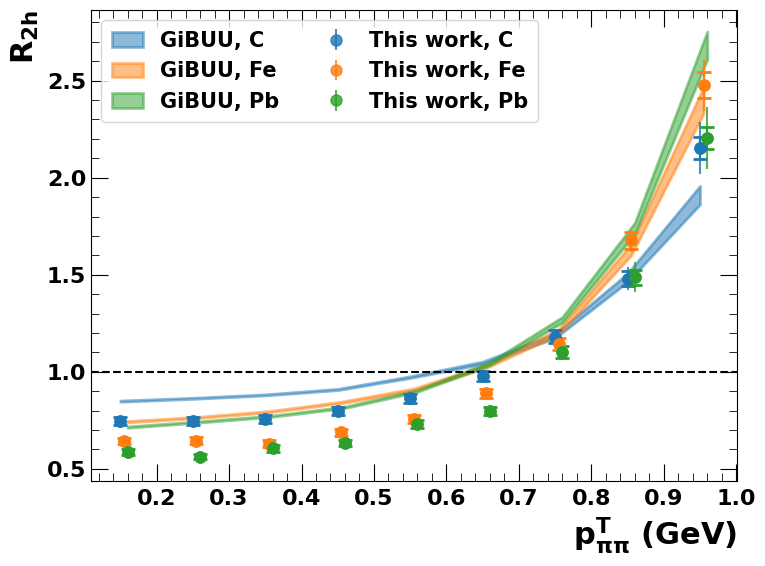

In [151]:
fig = plt.figure(figsize=(8,6))
colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']



ptTable={}
nbins=9
binningPt=dict(minz=0.1,maxz=1,nbins=nbins+1)

sysErr_pt = {a:pd.Series([np.sqrt(1+2**2+1+1) for i in range(nbins)]) for a in "C Fe Pb".split()}
print(sysErr_pt)
sysErr=sysErr_pt

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], 
                        df_trigger['D_%s_trigger'%target],variable='pair_pt',
                            **binningPt,
                            pair_cut='%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                            trig_cut = '%s '%trigger_cut_nom, applyweight=False)
    
    ptTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":minzmass,"max":maxzmass,"bins":dpionMassBins} 
    plt.errorbar(x+0.005*i,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    plt.errorbar(x+0.005*i,r,yerr=r*(sysErr[target]/100),fmt='o',ms=8,capthick=2,capsize=5,color=colorBands[i+1])
    
    #plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])
    
    ##GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                        df_trigger['GiBUU_D_trigger'],variable='pair_pt',
                            **binningPt,
                            pair_cut='and h2_z>0.05 and h2_z<0.45', trig_cut='h1_z>0.5',applyweight=False)
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    #plt.plot(x+0.005*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
    plt.fill_between(x+0.005*i,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=True,ncol=2,loc='upper left',fontsize=15)
plt.xlabel('$p^T_{\pi\pi}$ (GeV)',fontsize=22,fontweight='bold' )
plt.ylabel('R$_{\mathrm{2h}}$',fontsize=22,fontweight='bold')
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)
#plt.xscale('log')
#plt.ylim([0.0,1.2])
plt.tight_layout()
##plt.savefig('MainResult_withGiBUU_mass.png')

#for paper
outname='pt'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
plt.show()

In [135]:
As=[12,56, 207]
ravgs=[]
drtots=[]
drstats=[]
drsysts=[]
for a in "C Fe Pb".split():
    results=pd.DataFrame(z2Table[a])[1:-1]
    ravg=sum(results.r/(results.drstat**2))/sum(1/results.drstat**2)
    stat=np.sqrt(1/sum(1/results.drstat**2))
    syst=sum(0.01*results.r*results.drsys/(results.drstat**2))/sum(1/results.drstat**2)
    print("%.3f\\pm%.3f\pm%.3f"%(ravg,stat, syst), np.hypot(stat,syst))
    drsysts.append(syst)
    ravgs.append(ravg)
    drtots.append(np.hypot(stat,syst))
    drstats.append(stat)

0.836\pm0.007\pm0.024 0.025232914047413124
0.738\pm0.005\pm0.021 0.02206933332695013
0.698\pm0.008\pm0.020 0.021853830165552552


m= -0.06435219123879185 +- 0.004307110573823834
b= 0.973320950820328 +- 0.017108175224957656
3.3618813086318506
p= 0.7600105816705394
[-0.06438543  0.97319845]
0.007726435729206014 0.03064949516544148
0.553245105119882
Optimization terminated successfully.


<ipython-input-149-07b7c7ca19d5>:45: RuntimeWarning: divide by zero encountered in power
  plt.plot(x,np.exp(b)*x**m, label=f'fit, $R_{{2h}}={np.exp(b):.2f}A^{{{m:.3f}}}$, $\chi2$/dof={chi2/dof:.2f}')


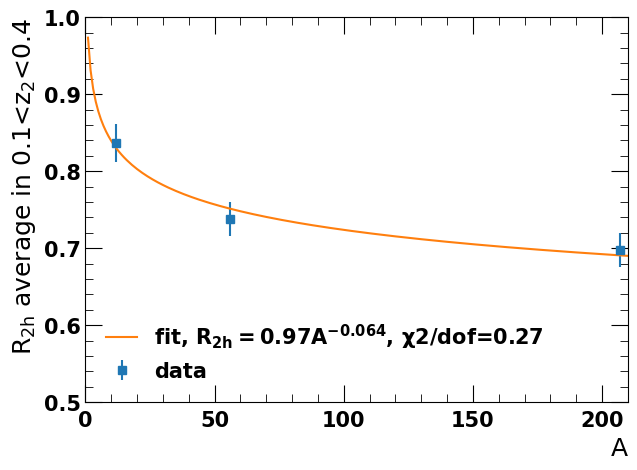

In [149]:
fig, axs=plt.subplots(1,1,figsize=(7,5))
#x=np.log([2]+As)
#y=np.log([1]+ravgs)
#dy=np.divide([.001]+drtots,[2]+ravgs)
corr=0
drs=np.hypot(drstats,np.multiply(drsysts,1-corr))
#drs=drtots
x=np.log(As)
y=np.log(ravgs)
dy=np.divide(drs,ravgs)


m=(sum(1/dy**2)*sum(x*y/dy**2)-sum(x/dy**2)*sum(y/dy**2))/(sum(1/dy**2)*sum(x*x/dy**2)-sum(x/dy**2)**2)
dm=1/np.sqrt(sum(x**2/dy**2))
b=(sum(y/dy**2)-m*sum(x/dy**2))/sum(1/dy**2)
db = 1/np.sqrt(sum(1/dy**2))
print("m=",m, "+-",dm)
print("b=",np.exp(b), "+-",np.exp(b)*db)
print(chi2)
chi2=sum((y-m*x-b)**2/dy**2)
dof=len(x)-1

from scipy.stats import chi2  as chi2lib
print("p=",chi2lib.sf(chi2,dof))


import scipy.optimize as opt
def chisqfunc(args):
    (m, b)=args
    chisq = np.sum([(ravgs[i]-b*As[i]**m)**2/drs[i]**2 for i in range(len(drs))])
    return chisq

x0 = np.array([-.06,1])
result =  opt.minimize(chisqfunc, x0)
print(result.x)
matrix=np.matrix(result.hess_inv)
print(np.sqrt(matrix[0,0]/2),np.sqrt(matrix[1,1]/2))
#print(np.sqrt(np.invert(np.matrix(result.hess_inv).get_inverse())),np.sqrt(result.hess_inv[1][1]))
print(result.fun)
print(result.message)


plt.errorbar(As,ravgs,drs, linestyle='', marker='s', label='data')
x= np.linspace(0,210, 211)
plt.plot(x,np.exp(b)*x**m, label=f'fit, $R_{{2h}}={np.exp(b):.2f}A^{{{m:.3f}}}$, $\chi2$/dof={chi2/dof:.2f}')
#plt.plot(x,result.x[1]*x**result.x[0], label=f'fit, $R_{{2h}}={np.exp(b):.2f}A^{{{m:.3f}}}$, $\chi2$/dof={chi2/dof:.2f}')


plt.ylim(0.5, 1)
plt.xlim(0, 210)
plt.legend(loc="lower left")
plt.ylabel("$R_{2h}$ average in 0.1<$z_2$<0.4")
plt.xlabel("A")
plt.show()

In [138]:
df['GiBUU_C'].columns

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso', '__index__',
       'inelasticity', 'h1_e', 'h1_p', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')

In [87]:
fig,axs = plt.subplots(4,2,figsize=(12,15), sharex='all',sharey='all')

dphidyTable={}


colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi

for ii in range(4):
    slice_cut=f" and {ii*np.pi/4}<dphi and dphi<{(ii+1)*np.pi/4}"
    for jj in range(2):    
        artists=[]
        trigger_cut_pid = [" and h1_pid==211"," and h1_pid==-211"][jj]
        
        
        
        mindy=0 if jj == 0 else -0.5
        maxdy=3 if jj == 0 else 2 
        nbins=7 if jj == 0 else 6
        
        plt.sca(axs[ii][jj])
        if ii == 0 and jj == 0:
            plt.title("$\pi^+\pi^-$")
        if ii == 0 and jj == 1:
            plt.title("$\pi^-\pi^+$")
        
        for j,target in enumerate(['C','Fe','Pb']):
            r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                minz=mindy,maxz=maxdy,nbins=nbins,variable='drap', 
                                    pair_cut = '%s and h2_z>0.05 and h2_z<0.45 and h1_cm_pt**2>0.005 and h2_cm_pt**2>0.005 and h1_z+h2_z<0.95'%pair_cut_nom + slice_cut,
                                    trig_cut = '%s'%trigger_cut_nom +trigger_cut_pid + " and h1_cm_pt**2>0.005")
                                    #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                                    #trig_cut = 'h1_z>0.5' 
            dphidyTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
            print('x is: ', x)
            print('r is: ', r) 
            print('err is: ', err) 
            print('sys err is:', sysErr[target]/100)
            stat=err
            #syst=r*(sysErr[target]/100)
            syst=0
            tot=np.hypot(stat,syst)
            
            #hide bins with huge errors
            while abs(tot[-1]/r[-1])>.4 or r[-1]==0:
                tot=list(tot)[:-1]
                err=list(err)[:-1]
                r=list(r)[:-1]
                x=list(x)[:-1]
            
            artists.append(plt.errorbar(np.subtract(x,-j*0.02),r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],
                         alpha=0.99,color=colors[target],)) #capsize=5, capthick=2)
            plt.errorbar(np.subtract(x,-j*0.02),r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[j+1])

            #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

        for j,target in enumerate(['C','Fe','Pb']):   
            #GiBUU
            r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                minz=mindy,maxz=maxdy,nbins=nbins,variable='drap', 
                                pair_cut='and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95' + slice_cut,
                                   trig_cut='h1_z>0.5'+trigger_cut_pid)
            artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])
            
        if ii == 3 and jj ==1:
            plt.legend(artists, [artist.get_label() for artist in artists],loc='upper right',fontsize=13.5,ncol=2)
        if ii==3:
            plt.xlabel('$\Delta y$',fontsize=18, fontweight='bold')
        if jj == 0:
            plt.ylabel(f'$\mathrm{{R}}_{{\mathrm{{2h}}}}(|\Delta\phi|, \Delta y)$',fontsize=14, fontweight='bold')
            plt.text(0.5, 1.7, f'${ii*45}^\\circ<|\Delta\phi|<{(ii+1)*45}^\\circ$', fontsize=16)
#         if jj == 1:
#             ax=plt.gca()
#             axr=plt.gca().twinx()
#             axr.sharey(ax)
#             lbl=f'${ii*np.pi/4:.2f}<|\Delta\phi|<{(ii+1)*np.pi/4:.2f}$'
#             lbl=f'${ii*45}^\\circ<|\Delta\phi|<{(ii+1)*45}^\\circ$'
#             axr.set_ylabel(lbl,fontsize=14, fontweight='bold', 
#                            horizontalalignment='center')
            #axr.yaxis.set_ticklabels([])
        
        plt.axhline(y=1.0,color='black',linestyle='--', linewidth=1, alpha=0.5)
        
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)

    plt.xlim(-0.5,3)
    plt.ylim(0)
    #plt.ylim([0.55,0.73])
    #plt.title('$0.10 < z_{2} < 0.50$')
    #plt.fill_between(x+0.005*j,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

#plt.text(0.10, 0.93,'c)',fontsize=20,
#     horizontalalignment='center',
#     verticalalignment='center',
#     transform = plt.gca().transAxes)    
    

#plt.legend(artists, [artist.get_label() for artist in artists],loc='lower left',fontsize=13.5,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

#for paper
outname='dphi_dy'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')


Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211 and h1_cm_pt**2>0.005
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.7

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.0<dphi and dphi<0.7853981633974483
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.0<dphi and dphi<0.7853981633974483
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211 and h1_cm_pt**2>0.005
Total Cut  h1_z>0.5 and h1_th>10 an

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.0<dphi and dphi<0.7853981633974483
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.0<dphi and dphi<0.7853981633974483
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211 and h1_cm_pt**2>0.005
Total Cut  h1_z>0.5 and h1_th>10

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.7853981633974483<dphi and dphi<1.5707963267948966
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.7853981633974483<dphi and dphi<1.5707963267948966
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211 and h1_cm_pt**2>0.005
Total

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.7853981633974483<dphi and dphi<1.5707963267948966
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.7853981633974483<dphi and dphi<1.5707963267948966
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211 and h1_cm_pt**2>0.005
To

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 1.5707963267948966<dphi and dphi<2.356194490192345
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 1.5707963267948966<dphi and dphi<2.356194490192345
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211 and h1_cm_pt**2>0.005
Total C

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 1.5707963267948966<dphi and dphi<2.356194490192345
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 1.5707963267948966<dphi and dphi<2.356194490192345
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211 and h1_cm_pt**2>0.005
Tota

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 2.356194490192345<dphi and dphi<3.141592653589793
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 2.356194490192345<dphi and dphi<3.141592653589793
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211 and h1_cm_pt**2>0.005
Total Cut

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 2.356194490192345<dphi and dphi<3.141592653589793
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 2.356194490192345<dphi and dphi<3.141592653589793


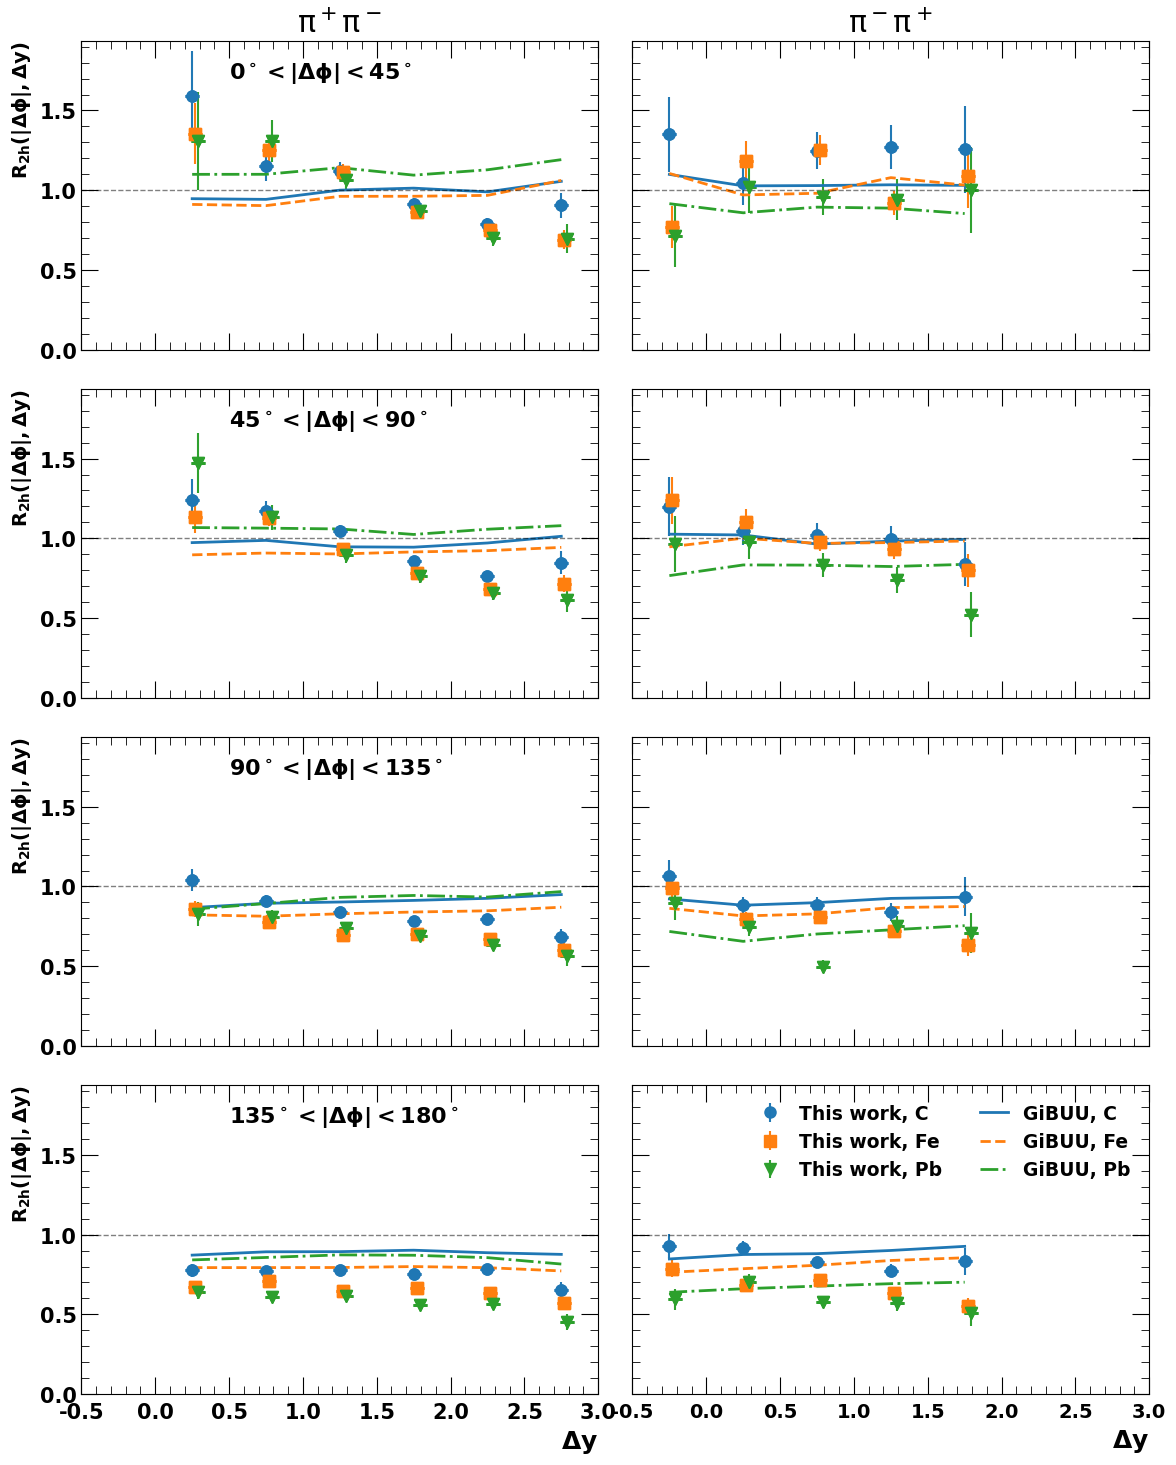

In [88]:
plt.show()

In [85]:
fig,axs = plt.subplots(4,2,figsize=(12,15), sharex='all',sharey='all')

z1z2Table={}


colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi

z1bins=[0.5,0.6,0.7,0.8,0.9]

for ii in range(4):
    slice_cut=f" and {z1bins[ii]}<h1_z and h1_z<{z1bins[ii+1]}"
    for jj in range(2):
        #bottom right panel is left blank, because there are just too few statistics for pi- at z>0.8
        if ii==3 and jj==1:
            axs[ii][jj].legend(artists, [artist.get_label() for artist in artists],loc='upper right',fontsize=13.5,ncol=2)
            continue
        
        artists=[]
        trigger_cut_pid = [" and h1_pid==211"," and h1_pid==-211"][jj]
        
        
        
        #minz2=0.05
        #maxz2=0.45
        #nbins=9 
        minz2=0.05
        maxz2=0.95-z1bins[ii] 
        nbins=1+round((maxz2-minz2)/.05)
        
        plt.sca(axs[ii][jj])
        if ii == 0 and jj == 0:
            plt.title("$\pi^+\pi^-$")
        if ii == 0 and jj == 1:
            plt.title("$\pi^-\pi^+$")
        
        for j,target in enumerate(['C','Fe','Pb']):
            r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                minz=minz2,maxz=maxz2,nbins=nbins,variable='h2_z', 
                                    pair_cut = '%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom + slice_cut,
                                    trig_cut = '%s'%trigger_cut_nom +trigger_cut_pid)
                                    #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                                    #trig_cut = 'h1_z>0.5' 
            
            z1z2Table[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
            print('x is: ', x)
            print('r is: ', r) 
            print('err is: ', err) 
            print('sys err is:', sysErr[target]/100)
            stat=err
            syst=r*(sysErr[target][:len(r)]/100)
            #syst=0
            tot=np.hypot(stat,syst)
            
            #hide bins with huge errors
#             while abs(tot[-1]/r[-1])>.7 or r[-1]==0:
#                 tot=list(tot)[:-2]
#                 err=list(err)[:-2]
#                 r=list(r)[:-2]
#                 x=list(x)[:-2]
            
            artists.append(plt.errorbar(np.subtract(x,-j*0.003),r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],
                         alpha=0.99,color=colors[target],)) #capsize=5, capthick=2)
            plt.errorbar(np.subtract(x,-j*0.003),r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[j+1])

            #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

        for j,target in enumerate(['C','Fe','Pb']):   
            #GiBUU
            r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                minz=minz2,maxz=maxz2,nbins=nbins,variable='h2_z', 
                                pair_cut='and h2_z>0.05 and h2_z<0.45' + slice_cut,
                                   trig_cut='h1_z>0.5'+trigger_cut_pid)
            
            artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])
            
            
        if ii==3:
            plt.xlabel('$z_2$',fontsize=18, fontweight='bold')
        if jj == 0:
            plt.ylabel(f'$\mathrm{{R}}_{{\mathrm{{2h}}}}(z_1, z_2)$',fontsize=14, fontweight='bold')
            plt.text(.05, 1.7, f"${z1bins[ii]}<z_1<{z1bins[ii+1]}$", fontsize=15)
        plt.axhline(y=1.0,color='black',linestyle='--', linewidth=1, alpha=0.5)
#axs[0][0].set_yscale('log')
axs[0][0].set_ylim(0,2.2)
axs[0][0].set_xlim(0,0.5)
axs[-1][0].set_xlabel("$z_2$")
axs[-1][1].set_xlabel("$z_2$")
plt.tight_layout()

outname='z1_z2'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nph

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nph

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nph

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.8<h1_z and h1_z<0.9
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.8<h1_z and h1_z<0.9


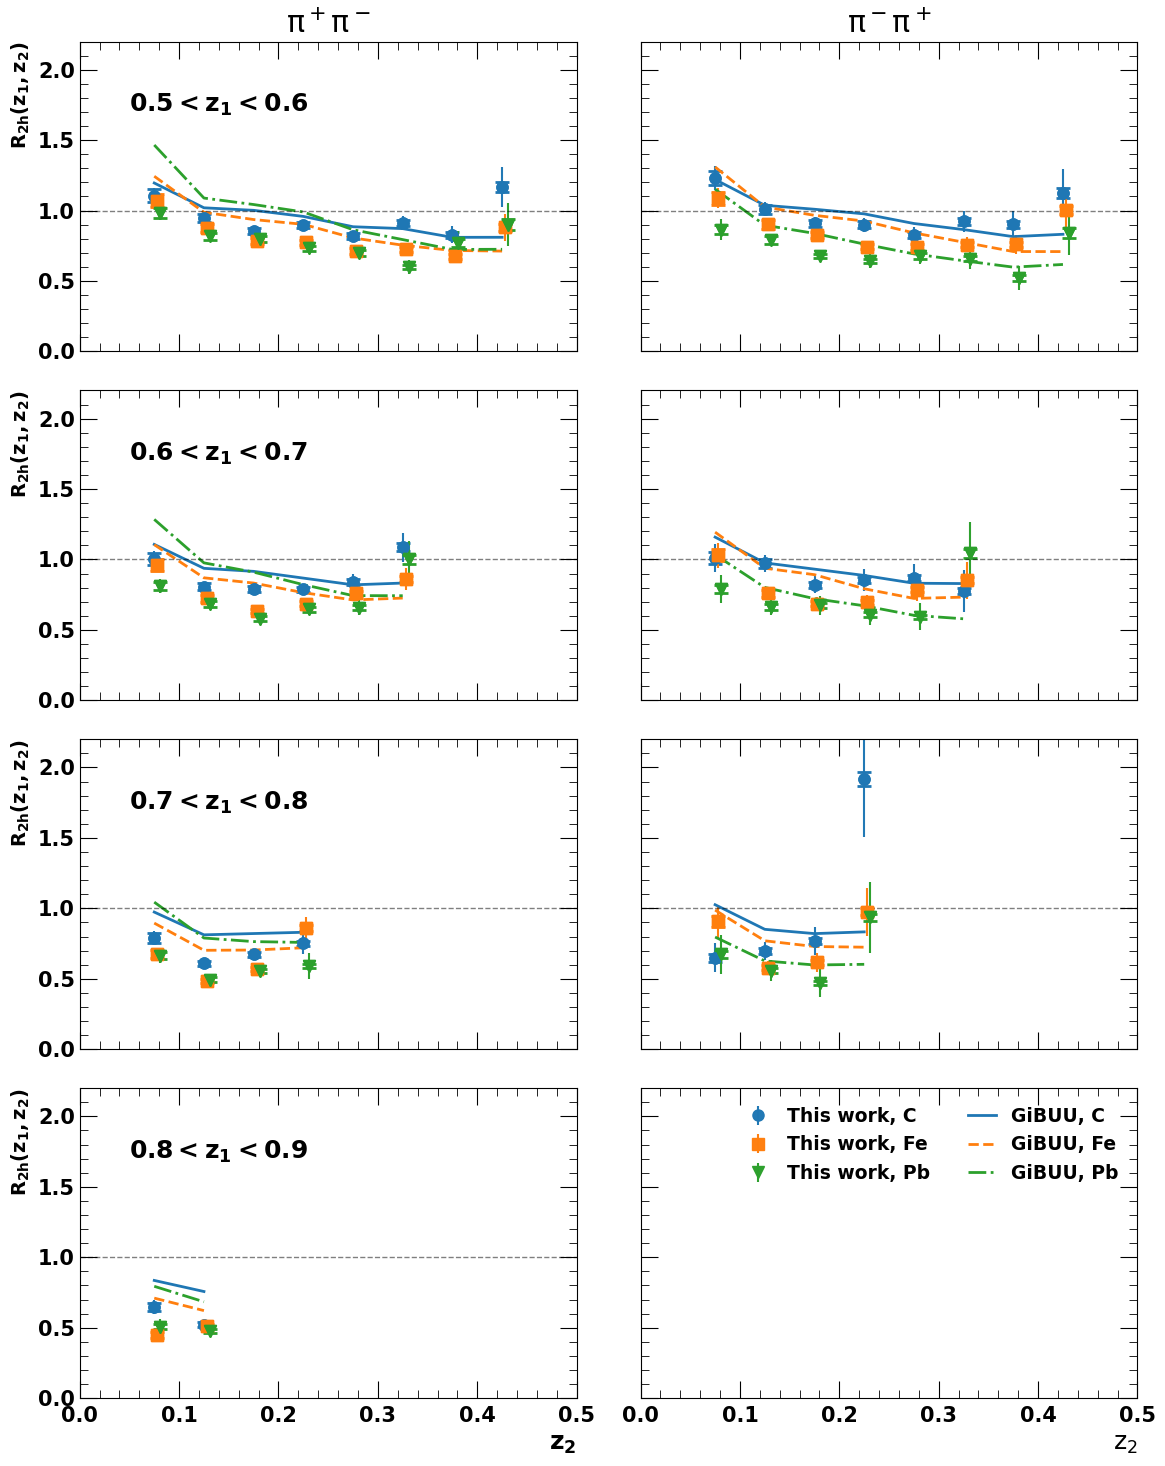

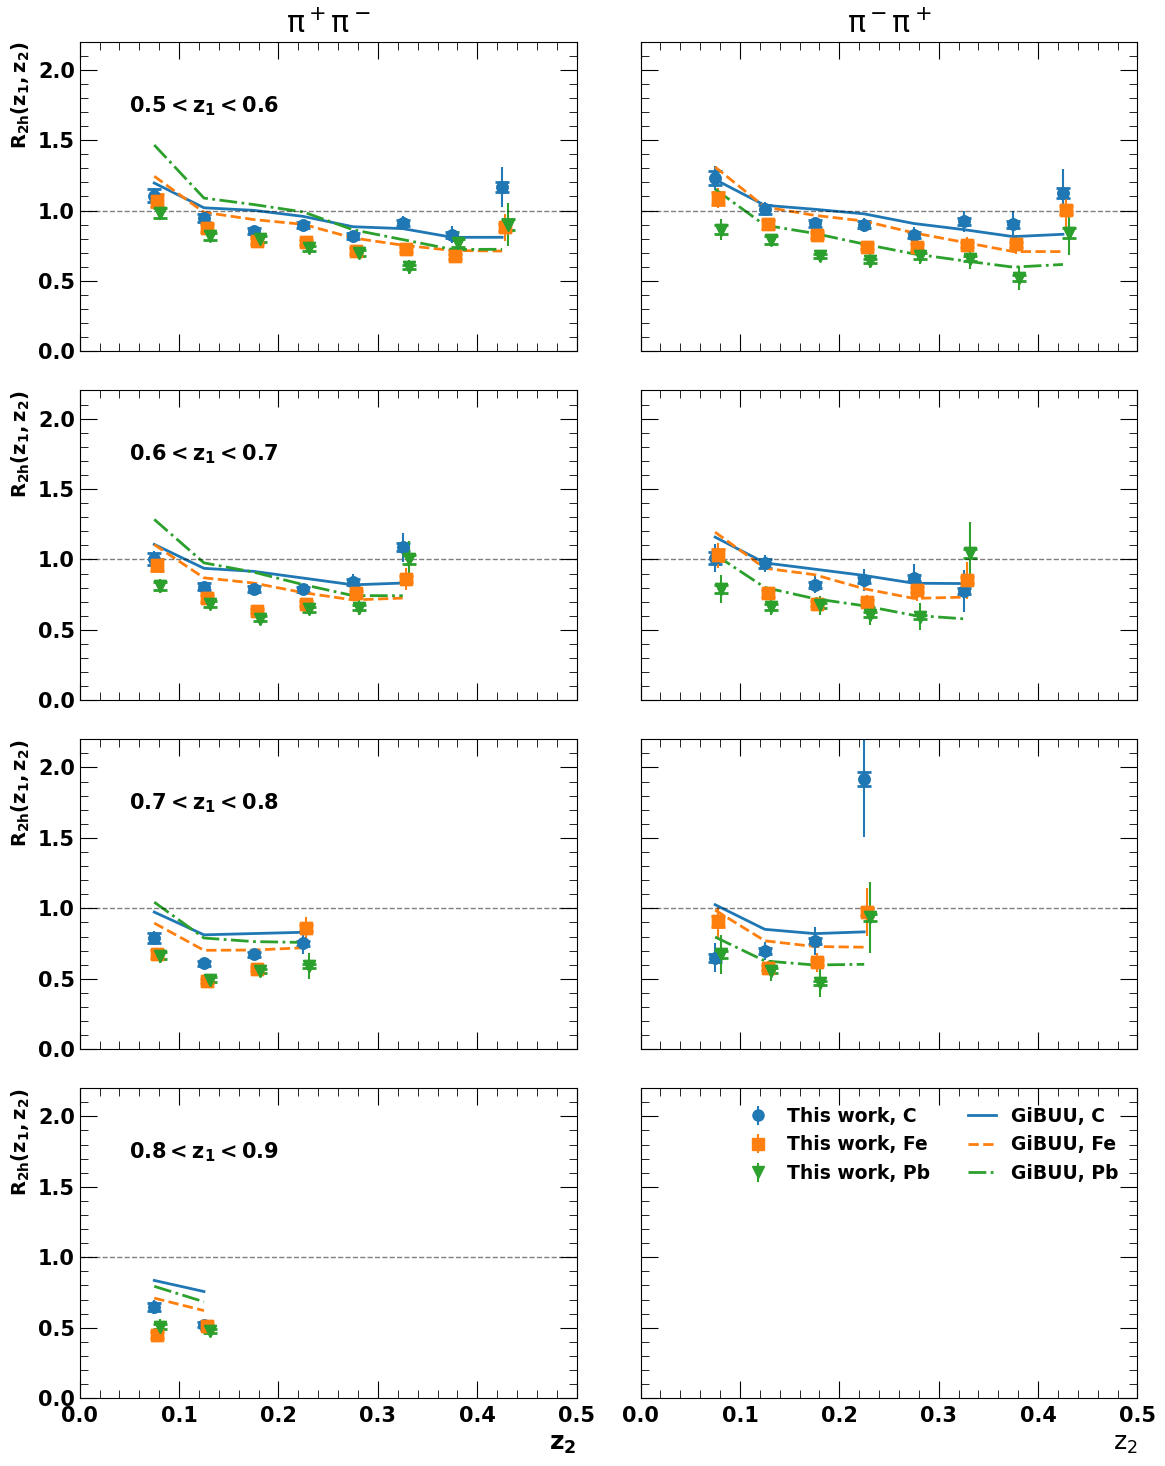

In [86]:

plt.show()

In [65]:
#z1 vs z2
fig,axs = plt.subplots(3,2,figsize=(12,12), sharex='all',sharey='all')

z1z2Table={}


#colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
colorsZ1='krgb'
linestylesZ1='- -- -. :'.split()
markersZ1='os^*'
sysErr=sysErr_dphi

z1bins=[0.5,0.6,0.7,0.8,0.9]

artists=[]
for ii in range(4):
    slice_cut=f" and {z1bins[ii]}<h1_z and h1_z<{z1bins[ii+1]}"
    for jj in range(2):
        
        trigger_cut_pid = [" and h1_pid==211"," and h1_pid==-211"][jj]
        
        
        
        #minz2=0.05
        #maxz2=0.45
        #nbins=9 
        minz2=0.05
        maxz2=0.95-z1bins[ii] 
        nbins=1+round((maxz2-minz2)/.05)
        
        
        
        for j,target in enumerate(['C','Fe','Pb']):
            r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                minz=minz2,maxz=maxz2,nbins=nbins,variable='h2_z', 
                                    pair_cut = '%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom + slice_cut,
                                    trig_cut = '%s'%trigger_cut_nom +trigger_cut_pid)
                                    #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                                    #trig_cut = 'h1_z>0.5' 
            
            plt.sca(axs[j][jj])
            z1z2Table[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
            print('x is: ', x)
            print('r is: ', r) 
            print('err is: ', err) 
            print('sys err is:', sysErr[target]/100)
            stat=err
            syst=r*(sysErr[target][:len(r)]/100)
            #syst=0
            tot=np.hypot(stat,syst)
            
            #hide bins with huge errors
#             while abs(tot[-1]/r[-1])>.7 or r[-1]==0:
#                 tot=list(tot)[:-2]
#                 err=list(err)[:-2]
#                 r=list(r)[:-2]
#                 x=list(x)[:-2]
            
            artists.append(plt.errorbar(np.subtract(x,-ii*0.0025),r,yerr=tot,label=f"${z1bins[ii]}<z_1<{z1bins[ii+1]}$",ms=6,fmt=markersZ1[ii],
                         alpha=0.99,color=colorsZ1[ii],)) #capsize=5, capthick=2)
            plt.errorbar(np.subtract(x,-ii*0.0025),r,yerr=syst,fmt=markersZ1[ii],ms=6,capthick=2,capsize=4,color=colorsZ1[ii])

            #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
            if jj == 0:
                plt.text(.03, 1.7, target, fontsize=20)
        for j,target in enumerate(['C','Fe','Pb']): 
            plt.sca(axs[j][jj])  
            #GiBUU
            r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                minz=minz2,maxz=maxz2,nbins=nbins,variable='h2_z', 
                                pair_cut='and h2_z>0.05 and h2_z<0.45' + slice_cut,
                                   trig_cut='h1_z>0.5'+trigger_cut_pid)
            
            artists.append(plt.plot(x,r,label=f'GiBUU, ${z1bins[ii]}<z_1<{z1bins[ii+1]}$',lw=2,color=colorsZ1[ii], linestyle=linestylesZ1[ii])[0])
            
            
        #if ii==3:
        #    plt.xlabel('$z_2$',fontsize=18, fontweight='bold')
        if jj == 0:
            for j in range(0,3):
                axs[j][jj].set_ylabel(f'$\mathrm{{R}}_{{\mathrm{{2h}}}}(z_1, z_2)$',fontsize=16, fontweight='bold')
            #plt.text(.05, 1.7, target, fontsize=15)
#axs[0][0].set_yscale('log')

axs[0][0].set_title("$\pi^+\pi^-$")
axs[0][1].set_title("$\pi^-\pi^+$")

artists=artists[::3]
artists=[artists[i] for i in [0, 4, 8, 12, 1,5, 9, 13]]
print([artist.get_label() for artist in artists])

for axss in axs:
    for ax in axss:
        ax.axhline(y=1.0,color='black',linestyle='--', linewidth=1, alpha=0.5)
axs[0][0].legend(artists, [artist.get_label() for artist in artists],loc='upper right',fontsize=12,ncol=2)
axs[0][0].set_ylim(0,2.2)
axs[0][0].set_xlim(0,0.5)
axs[-1][0].set_xlabel("$z_2$")
axs[-1][1].set_xlabel("$z_2$")
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
outname='z1_z2'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nph

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.5<h1_z and h1_z<0.6
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nph

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.6<h1_z and h1_z<0.7
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nph

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.7<h1_z and h1_z<0.8
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.8<h1_z and h1_z<0.9
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211and h2_z>0.05 and h2_z<0.45 and 0.8<h1_z and h1_z<0.9
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nph

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.8<h1_z and h1_z<0.9
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211and h2_z>0.05 and h2_z<0.45 and 0.8<h1_z and h1_z<0.9
['$0.5<z_1<0.6$', '$0.6<z_1<0.7$', '$0.7<z_1<0.8$', '$0.8<z_1<0.9$', 'GiBUU, $0.5<z_1<0.6$', 'GiBUU, $0.6<z_1<0.7$', 'GiBUU, $0.7<z_1<0.8$', 'GiBUU, $0.8<z_1<0.9$']


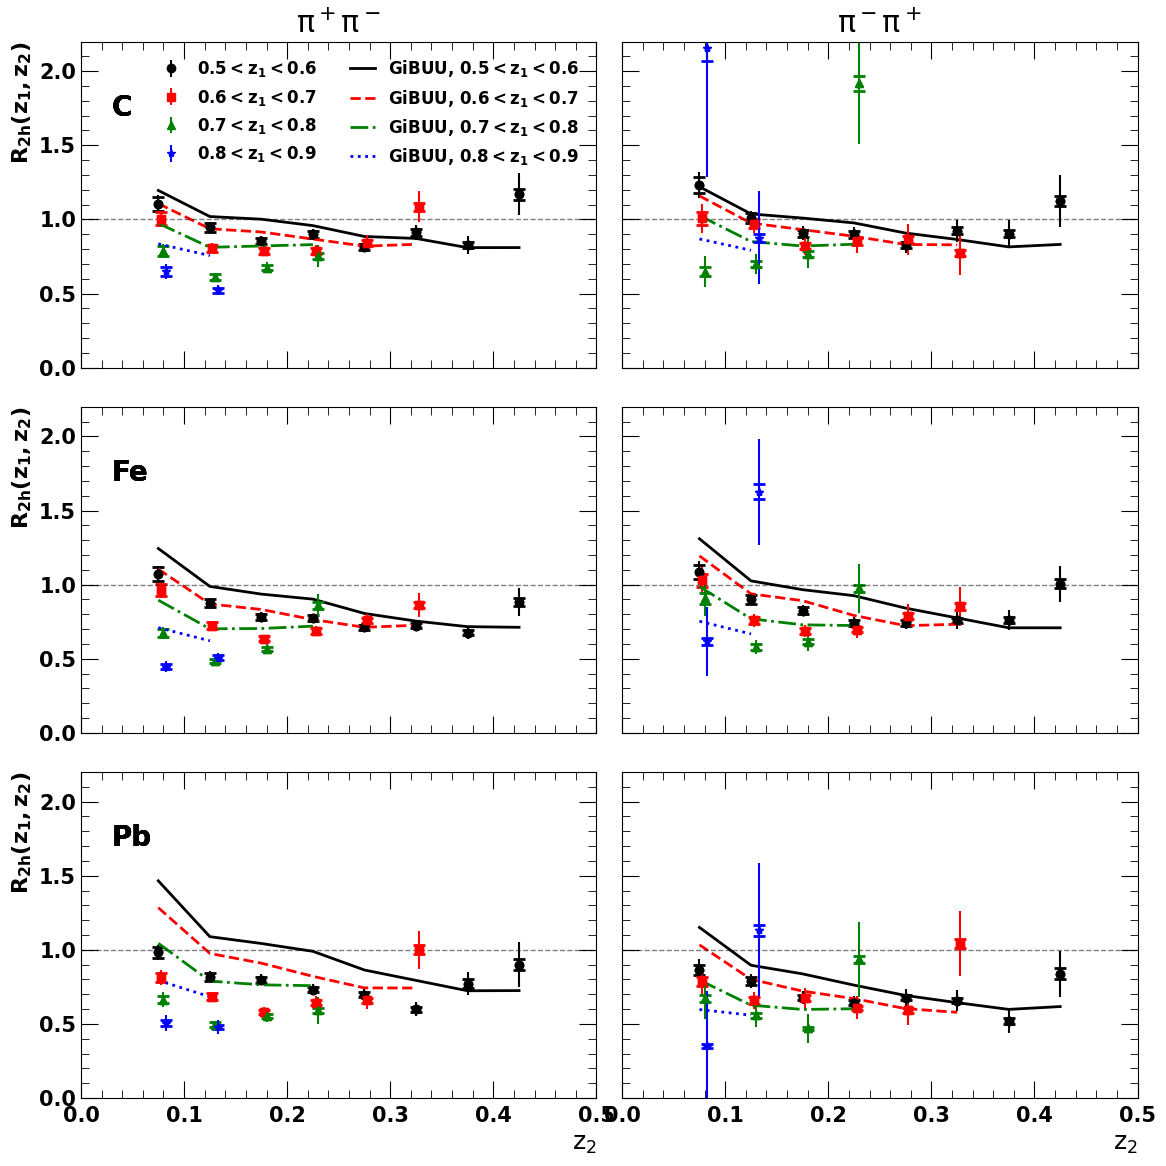

In [66]:

plt.show()

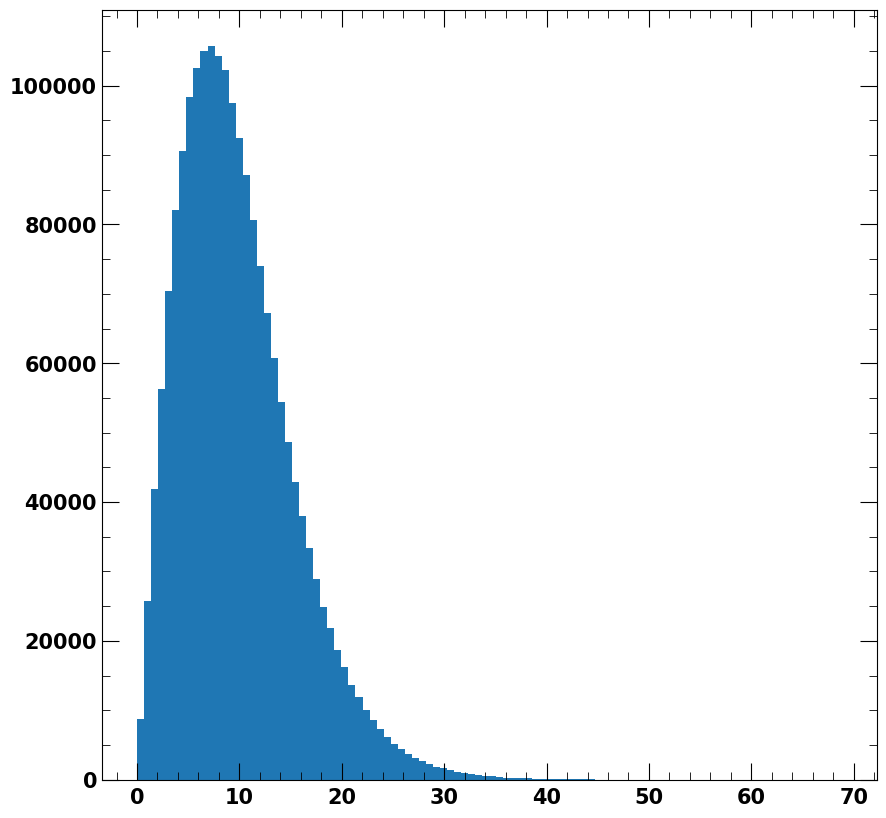

In [61]:
#plt.hist(df['GiBUU_D'].eval(f"h2_p*sin(h2_th*{np.pi/180})"),bins=100)
plt.hist(df_trigger['GiBUU_D_trigger'].eval(f"h1_th"),bins=100)
plt.show()

In [64]:
#Idk why we don't have pt in the GiBUU tuples, nor why the theta is using different units for the h1 and h2, 
#and is negative for some values of h2.  Anyways, patching this issue.
for key in df.keys():
    if 'GiBUU' in key:
        if "h1_cm_pt" not in df[key].columns:
            df[key]['h1_cm_pt']= df[key].eval(f"h1_p*sin(h1_th*{np.pi/180})>0.3")
        if "h2_cm_pt" not in df[key]:
            df[key]['h2_cm_pt']= df[key].eval(f"h2_p*sin(h2_th+{np.pi/2}*(h2_th<0))>0.3")
for key in df_trigger.keys():
    if 'GiBUU' in key:
        if "h1_cm_pt" not in df_trigger[key].columns:
            df_trigger[key]['h1_cm_pt']= df_trigger[key].eval(f"h1_p*sin(h1_th*{np.pi/180})>0.3")

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))   and h1_cm_pt>0.3
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==21

Print Trigger Cut  h1_z>0.5 and h1_cm_pt>0.3
Total Cut  h1_z>0.5 and h1_cm_pt>0.3and h2_z>0.05 and h2_z<0.45  and h2_cm_pt>0.3 and h1_cm_pt>0.3
Print Trigger Cut  h1_z>0.5 and h1_cm_pt>0.3
Total Cut  h1_z>0.5 and h1_cm_pt>0.3and h2_z>0.05 and h2_z<0.45  and h2_cm_pt>0.3 and h1_cm_pt>0.3


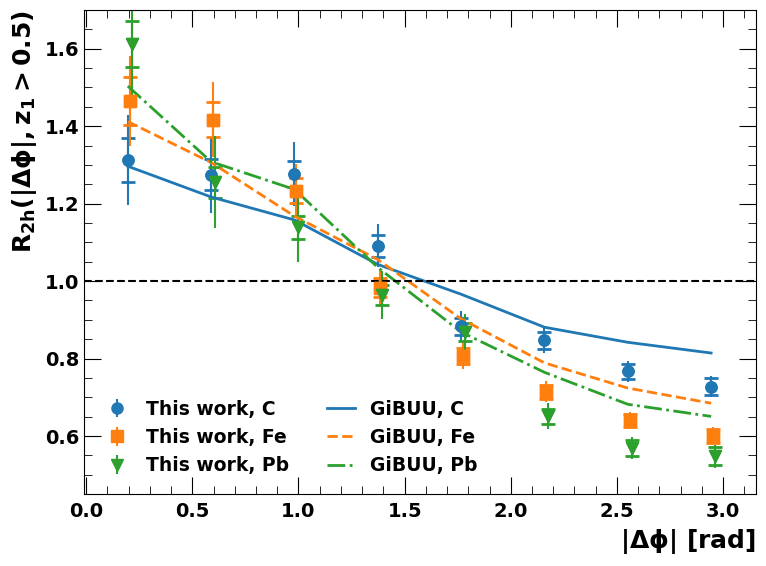

In [65]:
fig = plt.figure(figsize=(8,6))

dphiTable={}

artists=[]

colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                            pair_cut = '%s and h2_z>0.05 and h2_z<0.45 and h2_cm_pt>0.3 and h1_cm_pt>0.3'%pair_cut_nom,
                            trig_cut = '%s and h1_cm_pt>0.3'%trigger_cut_nom )
                            #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                            #trig_cut = 'h1_z>0.5' 
    dphiTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
    print('x is: ', x)
    print('r is: ', r) 
    print('err is: ', err) 
    print('sys err is:', sysErr[target]/100)
    stat=err
    syst=r*(sysErr[target]/100)
    tot=np.hypot(stat,syst)
    artists.append(plt.errorbar(np.subtract(x,-j*0.009),r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],
                 alpha=0.99,color=colors[target],)) #capsize=5, capthick=2)
    plt.errorbar(np.subtract(x,-j*0.009),r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[j+1])
    
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
for j,target in enumerate(['C','Fe','Pb']):   
    #GiBUU
    r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dphi', 
                        pair_cut=f'and h2_z>0.05 and h2_z<0.45  and h2_cm_pt>0.3 and h1_cm_pt>0.3',
                           trig_cut=f'h1_z>0.5 and h1_cm_pt>0.3')
    artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])
    #plt.fill_between(x+0.005*j,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

#plt.text(0.10, 0.93,'c)',fontsize=20,
#     horizontalalignment='center',
#     verticalalignment='center',
#     transform = plt.gca().transAxes)    
    
plt.xlabel('$|\Delta\phi|$ [rad]',fontsize=18, fontweight='bold')
plt.ylabel('$\mathrm{R}_{\mathrm{2h}}(|\Delta\phi|,\mathrm{z}_1>0.5)$',fontsize=18, fontweight='bold')
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)

plt.xlim([-0.01,3.155])
plt.ylim([0.45,1.7])
#plt.ylim([0.55,0.73])
#plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(artists, [artist.get_label() for artist in artists],loc='lower left',fontsize=13.5,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

#for paper
outname='dphi_tight'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
plt.show()

In [75]:
"h2_z" in df['C'].columns

True

In [82]:
fig,axs = plt.subplots(4,2,figsize=(12,15), sharex='all',sharey='all')

dphidyTable={}


colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi
slice_cuts=[0.55,0.65, 0.75, 0.85, 0.95]
for ii in range(4):
    slice_cut=f" and {slice_cuts[ii]}<h1_z+h2_z and h1_z+h2_z<={slice_cuts[ii+1]}"
    for jj in range(2):    
        artists=[]
        trigger_cut_pid = [" and h1_pid==211"," and h1_pid==-211"][jj]
        
        
        plt.sca(axs[ii][jj])
        if ii == 0 and jj == 0:
            plt.title("$\pi^+\pi^-$")
        if ii == 0 and jj == 1:
            plt.title("$\pi^-\pi^+$")
        
        for j,target in enumerate(['C','Fe','Pb']):
            r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                minz=0.3,maxz=1.7,nbins=11,variable='pair_mass', 
                                    pair_cut = ('%s and h2_z>0.05 and h2_z<0.45 and h1_cm_pt**2>0.005 and h2_cm_pt**2>0.005 and h1_z+h2_z<0.95'%pair_cut_nom) + slice_cut,
                                    trig_cut = '%s '%trigger_cut_nom +trigger_cut_pid)
                                    #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                                    #trig_cut = 'h1_z>0.5' 
            dphidyTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
            print('x is: ', x)
            print('r is: ', r) 
            print('err is: ', err) 
            print('sys err is:', sysErr[target]/100)
            stat=err
            #syst=r*(sysErr[target]/100)
            syst=0
            tot=np.hypot(stat,syst)
            
            #hide bins with huge errors
            while abs(tot[-1]/r[-1])>.4 or r[-1]==0:
                tot=list(tot)[:-1]
                err=list(err)[:-1]
                r=list(r)[:-1]
                x=list(x)[:-1]
            
            artists.append(plt.errorbar(np.subtract(x,-j*0.02),r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],
                         alpha=0.99,color=colors[target],)) #capsize=5, capthick=2)
            plt.errorbar(np.subtract(x,-j*0.02),r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[j+1])

            #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

        for j,target in enumerate(['C','Fe','Pb']):   
            #GiBUU
            r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                minz=0.3,maxz=1.7,nbins=11,variable='pair_mass', 
                                pair_cut=' and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95' + slice_cut,
                                   trig_cut='h1_z>0.5'+trigger_cut_pid)
            artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])
            
        if ii == 3 and jj ==1:
            plt.legend(artists, [artist.get_label() for artist in artists],loc='upper right',fontsize=13.5,ncol=2)
        if ii==3:
            plt.xlabel('$\mathrm{m}_{\\pi\\pi}$ [GeV]',fontsize=18, fontweight='bold')
        if jj == 0:
            plt.ylabel(f'$\mathrm{{R}}_{{\mathrm{{2h}}}}(m_{{\\pi\\pi}}, \mathrm{{z}}_{{\mathrm{{tot}}}})$',fontsize=14, fontweight='bold')
            plt.text(0.5, 1.7, f'${slice_cuts[ii]}<\\mathrm{{z}}_{{\\mathrm{{tot}}}}<{slice_cuts[ii+1]}$', fontsize=16)
#         if jj == 1:
#             ax=plt.gca()
#             axr=plt.gca().twinx()
#             axr.sharey(ax)
#             lbl=f'${ii*np.pi/4:.2f}<|\Delta\phi|<{(ii+1)*np.pi/4:.2f}$'
#             lbl=f'${ii*45}^\\circ<|\Delta\phi|<{(ii+1)*45}^\\circ$'
#             axr.set_ylabel(lbl,fontsize=14, fontweight='bold', 
#                            horizontalalignment='center')
            #axr.yaxis.set_ticklabels([])
        
        plt.axhline(y=1.0,color='black',linestyle='--', linewidth=1, alpha=0.5)
        
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)

    #plt.xlim(-0.5,3)
    plt.ylim(0)
    #plt.ylim([0.55,0.73])
    #plt.title('$0.10 < z_{2} < 0.50$')
    #plt.fill_between(x+0.005*j,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

#plt.text(0.10, 0.93,'c)',fontsize=20,
#     horizontalalignment='center',
#     verticalalignment='center',
#     transform = plt.gca().transAxes)    
    

#plt.legend(artists, [artist.get_label() for artist in artists],loc='lower left',fontsize=13.5,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

#for paper
outname='mass_dztot'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')



Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==21

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.55<h1_z+h2_z and h1_z+h2_z<=0.65
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.55<h1_z+h2_z and h1_z+h2_z<=0.65
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 an

/home/sebouh/di-hadron/R2h_module.py:15: RuntimeWarning: invalid value encountered in true_divide
  err_A = np.true_divide(np.sqrt(erry_A),y_A)
/home/sebouh/di-hadron/R2h_module.py:16: RuntimeWarning: invalid value encountered in true_divide
  err_D = np.true_divide(np.sqrt(erry_D),y_D)
/home/sebouh/di-hadron/R2h_module.py:19: RuntimeWarning: invalid value encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/sebouh/di-hadron/R2h_module.py:15: RuntimeWarning: invalid value encountered in true_divide
  err_A = np.true_divide(np.sqrt(erry_A),y_A)


x is:  [0.37 0.51 0.65 0.79 0.93 1.07 1.21 1.35 1.49 1.63]
r is:  [1.07056337 1.13383543 1.2092791  0.98219941 0.92197691 0.86396342
 1.51392799 0.7771497  1.11021386 0.        ]
err is:  [0.18673056 0.10608745 0.10342137 0.07284864 0.09085196 0.12818012
 0.33074138 0.35573072 1.01348196        nan]
sys err is: [0.04256489 0.0315625  0.02614883 0.02523107 0.0253356  0.02547747
 0.02627595 0.03001707]
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and

/home/sebouh/di-hadron/R2h_module.py:15: RuntimeWarning: invalid value encountered in true_divide
  err_A = np.true_divide(np.sqrt(erry_A),y_A)
/home/sebouh/di-hadron/R2h_module.py:16: RuntimeWarning: invalid value encountered in true_divide
  err_D = np.true_divide(np.sqrt(erry_D),y_D)
/home/sebouh/di-hadron/R2h_module.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)
/home/sebouh/di-hadron/R2h_module.py:19: RuntimeWarning: invalid value encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.55<h1_z+h2_z and h1_z+h2_z<=0.65
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.55<h1_z+h2_z and h1_z+h2_z<=0.65
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.65<h1_z+h2_z and h1_z+h2_z<=0.75
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.65<h1_z+h2_z and h1_z+h2_z<=0.75
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 an

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.65<h1_z+h2_z and h1_z+h2_z<=0.75
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.65<h1_z+h2_z and h1_z+h2_z<=0.75
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.75<h1_z+h2_z and h1_z+h2_z<=0.85
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.75<h1_z+h2_z and h1_z+h2_z<=0.85
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 an

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.75<h1_z+h2_z and h1_z+h2_z<=0.85
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.75<h1_z+h2_z and h1_z+h2_z<=0.85
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0

Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.85<h1_z+h2_z and h1_z+h2_z<=0.95
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.85<h1_z+h2_z and h1_z+h2_z<=0.95
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 an

Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.85<h1_z+h2_z and h1_z+h2_z<=0.95
Print Trigger Cut  h1_z>0.5 and h1_pid==-211
Total Cut  h1_z>0.5 and h1_pid==-211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0.85<h1_z+h2_z and h1_z+h2_z<=0.95


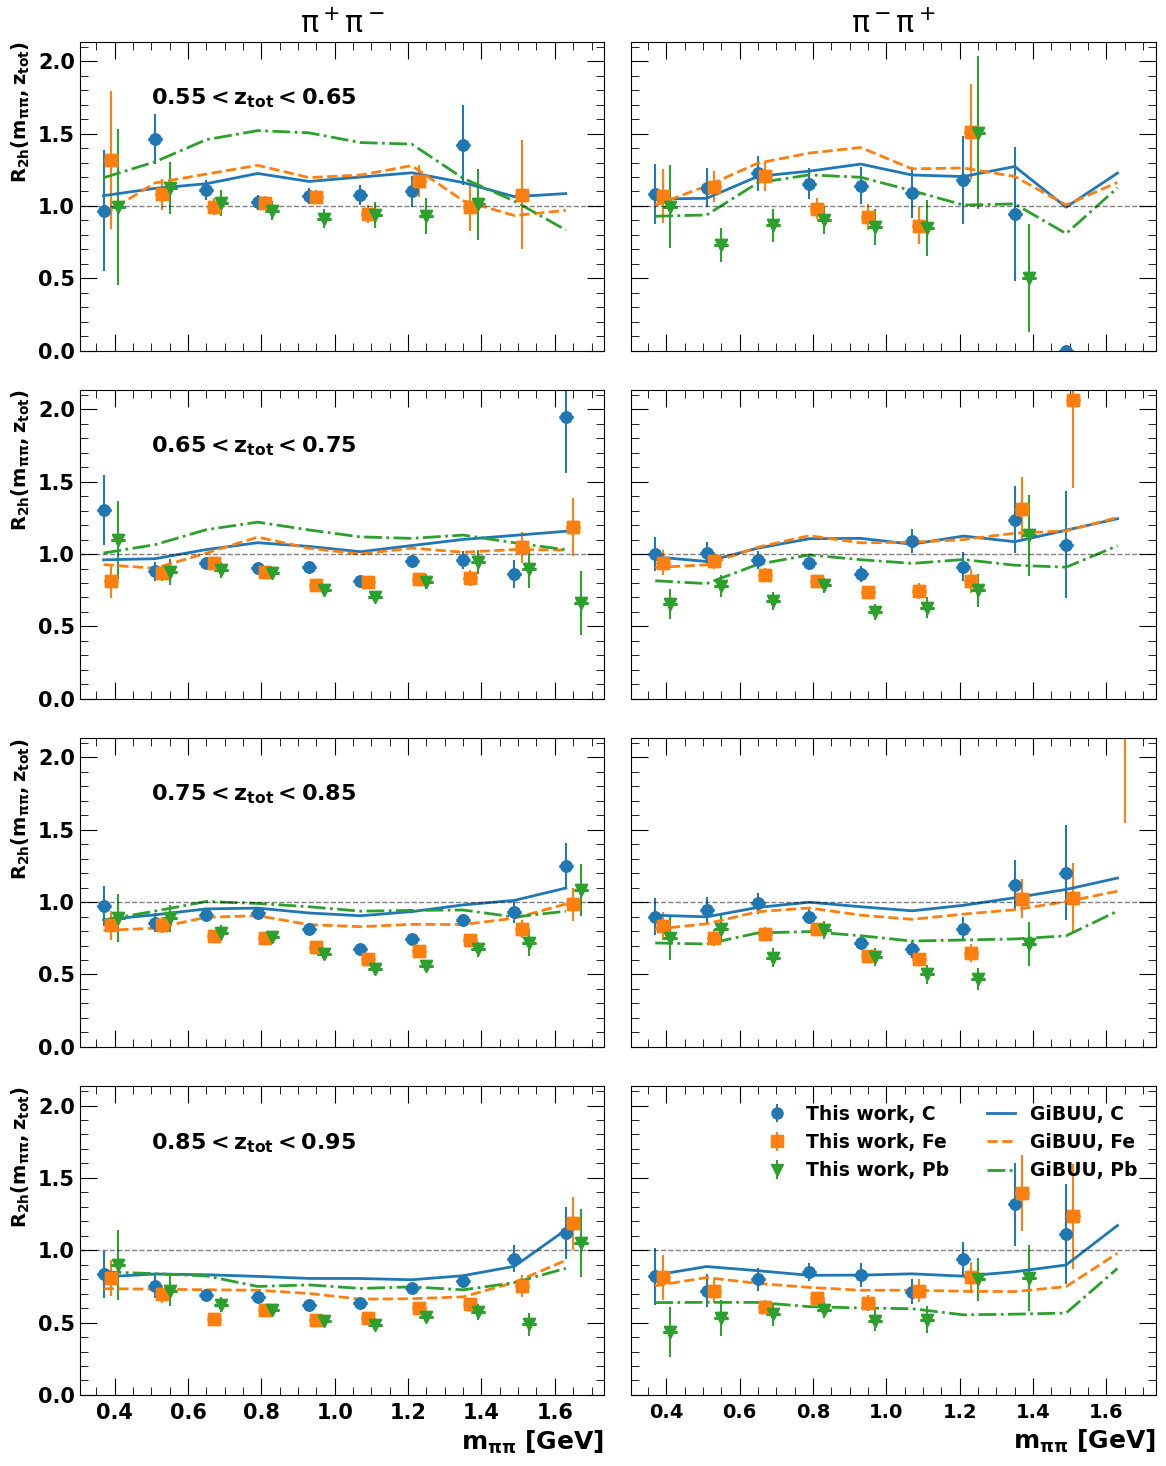

In [83]:
plt.show()

In [95]:
fig,axs = plt.subplots(3,2,figsize=(12,12), sharex='all',sharey='all')

dphidyTable={}


colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi
slice_cuts=[0, 0.2, 0.4, 1.0]
for ii in range(3):
    slice_cut=f" and {slice_cuts[ii]}<pair_pt and pair_pt<={slice_cuts[ii+1]}"
    for jj in range(2):    
        artists=[]
        trigger_cut_pid = [" and h1_pid==211"," and h1_pid==-211"][jj]
        
        
        plt.sca(axs[ii][jj])
        if ii == 0 and jj == 0:
            plt.title("$\pi^+\pi^-$")
        if ii == 0 and jj == 1:
            plt.title("$\pi^-\pi^+$")
        
        for j,target in enumerate(['C','Fe','Pb']):
            r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                minz=0.3,maxz=1.7,nbins=11,variable='pair_mass', 
                                    pair_cut = ('%s and h2_z>0.05 and h2_z<0.45 and h1_cm_pt**2>0.005 and h2_cm_pt**2>0.005 and h1_z+h2_z<0.95'%pair_cut_nom) + slice_cut,
                                    trig_cut = '%s '%trigger_cut_nom +trigger_cut_pid)
                                    #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                                    #trig_cut = 'h1_z>0.5' 
            dphidyTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
            print('x is: ', x)
            print('r is: ', r) 
            print('err is: ', err) 
            print('sys err is:', sysErr[target]/100)
            stat=err
            #syst=r*(sysErr[target]/100)
            syst=0
            tot=np.hypot(stat,syst)
            
            #hide bins with huge errors
            while abs(tot[-1]/r[-1])>.4 or r[-1]==0:
                tot=list(tot)[:-1]
                err=list(err)[:-1]
                r=list(r)[:-1]
                x=list(x)[:-1]
            
            artists.append(plt.errorbar(np.subtract(x,-j*0.02),r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],
                         alpha=0.99,color=colors[target],)) #capsize=5, capthick=2)
            plt.errorbar(np.subtract(x,-j*0.02),r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[j+1])

            #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

        for j,target in enumerate(['C','Fe','Pb']):   
            #GiBUU
            r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                minz=0.3,maxz=1.7,nbins=11,variable='pair_mass', 
                                pair_cut=' and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95' + slice_cut,
                                   trig_cut='h1_z>0.5'+trigger_cut_pid)
            artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])
            
        if ii == 2 and jj ==1:
            plt.legend(artists, [artist.get_label() for artist in artists],loc='upper right',fontsize=13.5,ncol=2)
        if ii==2:
            plt.xlabel('$\mathrm{m}_{\\pi\\pi}$ [GeV]',fontsize=18, fontweight='bold')
        if jj == 0:
            plt.ylabel(f'$\mathrm{{R}}_{{\mathrm{{2h}}}}(m_{{\\pi\\pi}}, \mathrm{{z}}_{{\mathrm{{tot}}}})$',fontsize=14, fontweight='bold')
            plt.text(0.5, 1.7, f'${slice_cuts[ii]}<p^\\mathrm{{pair}}_T<{slice_cuts[ii+1]}$', fontsize=16)
#         if jj == 1:
#             ax=plt.gca()
#             axr=plt.gca().twinx()
#             axr.sharey(ax)
#             lbl=f'${ii*np.pi/4:.2f}<|\Delta\phi|<{(ii+1)*np.pi/4:.2f}$'
#             lbl=f'${ii*45}^\\circ<|\Delta\phi|<{(ii+1)*45}^\\circ$'
#             axr.set_ylabel(lbl,fontsize=14, fontweight='bold', 
#                            horizontalalignment='center')
            #axr.yaxis.set_ticklabels([])
        
        plt.axhline(y=1.0,color='black',linestyle='--', linewidth=1, alpha=0.5)
        
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)

    #plt.xlim(-0.5,3)
    plt.ylim(.3, 5)
    plt.yscale('log')
    #plt.ylim([0.55,0.73])
    #plt.title('$0.10 < z_{2} < 0.50$')
    #plt.fill_between(x+0.005*j,r-err,r+err,label='GiBUU, %s'%target,alpha=0.5,lw=2,color=colors[target])

#plt.text(0.10, 0.93,'c)',fontsize=20,
#     horizontalalignment='center',
#     verticalalignment='center',
#     transform = plt.gca().transAxes)    
    

#plt.legend(artists, [artist.get_label() for artist in artists],loc='lower left',fontsize=13.5,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

#for paper
outname='mass_pairpt'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')




Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==21

/home/sebouh/di-hadron/R2h_module.py:16: RuntimeWarning: invalid value encountered in true_divide
  err_D = np.true_divide(np.sqrt(erry_D),y_D)
/home/sebouh/di-hadron/R2h_module.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)


x is:  [0.37 0.51 0.65 0.79 0.93 1.07 1.21 1.35 1.49 1.63]
r is:  [0.70110176 0.65436164 0.62234363 0.79163603 0.63144982 0.55553968
 0.57354515 0.63594286 0.59428813 0.56632685]
err is:  [0.36894415 0.14415989 0.05789554 0.03988582 0.02905348 0.02720704
 0.03163946 0.04699533 0.06710505 0.11461473]
sys err is: [0.04256489 0.0315625  0.02614883 0.02523107 0.0253356  0.02547747
 0.02627595 0.03001707]
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and

/home/sebouh/di-hadron/R2h_module.py:15: RuntimeWarning: invalid value encountered in true_divide
  err_A = np.true_divide(np.sqrt(erry_A),y_A)


Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0<pair_pt and pair_pt<=0.2
Print Trigger Cut  h1_z>0.5 and h1_pid==211
Total Cut  h1_z>0.5 and h1_pid==211 and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95 and 0<pair_pt and pair_pt<=0.2
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and h1_pid==-211
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 an

/home/sebouh/di-hadron/R2h_module.py:16: RuntimeWarning: invalid value encountered in true_divide
  err_D = np.true_divide(np.sqrt(erry_D),y_D)
/home/sebouh/di-hadron/R2h_module.py:19: RuntimeWarning: divide by zero encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/sebouh/di-hadron/R2h_module.py:15: RuntimeWarning: invalid value encountered in true_divide
  err_A = np.true_divide(np.sqrt(erry_A),y_A)
/home/sebouh/.local/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, i

x is:  [0.37 0.51 0.65 0.79 0.93 1.07 1.21 1.35 1.49 1.63]
r is:  [0.         0.67846403 0.8646858  0.69735308 0.46328473 0.45547235
 0.48770109 0.756964   0.7771497  0.27755347]
err is:  [       nan 0.24268358 0.14503517 0.07175518 0.06088787 0.06424987
 0.08660382 0.18258659 0.35573072 0.29979201]
sys err is: [0.04256489 0.0315625  0.02614883 0.02523107 0.0253356  0.02547747
 0.02627595 0.03001707]
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and

x is:  [0.37 0.51 0.65 0.79 0.93 1.07 1.21 1.35 1.49 1.63]
r is:  [0.64923943 0.63220736 0.70073256 0.6556871  0.60693987 0.58791228
 0.60076486 0.60800176 0.7271716  0.93991454]
err is:  [0.1482772  0.05468626 0.03051572 0.01861491 0.01819019 0.01933306
 0.02198294 0.03041197 0.05785445 0.1162965 ]
sys err is: [0.04256489 0.0315625  0.02614883 0.02523107 0.0253356  0.02547747
 0.02627595 0.03001707]
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and

x is:  [0.37 0.51 0.65 0.79 0.93 1.07 1.21 1.35 1.49 1.63]
r is:  [0.63440792 0.72503762 0.65106241 0.57954856 0.53193256 0.4852106
 0.63757996 0.91072231 0.77173403 2.08165099]
err is:  [0.15217816 0.07677823 0.04935955 0.03319063 0.03368602 0.03908658
 0.06476956 0.13538313 0.21417785 0.98741376]
sys err is: [0.04256489 0.0315625  0.02614883 0.02523107 0.0253356  0.02547747
 0.02627595 0.03001707]
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and 

x is:  [0.37 0.51 0.65 0.79 0.93 1.07 1.21 1.35 1.49 1.63]
r is:  [0.78001646 0.87881983 0.79981469 0.79362811 0.82411568 0.79571912
 0.90393695 0.96767311 1.24311559 1.78879233]
err is:  [0.06871393 0.0386064  0.02264397 0.01664273 0.02040346 0.02413873
 0.03183567 0.0495014  0.10796091 0.24572046]
sys err is: [0.04256489 0.0315625  0.02614883 0.02523107 0.0253356  0.02547747
 0.02627595 0.03001707]
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and

x is:  [0.37 0.51 0.65 0.79 0.93 1.07 1.21 1.35 1.49 1.63]
r is:  [0.89947882 0.87951518 0.82564244 0.85595377 0.80428665 0.88956466
 0.95675882 1.49878871 1.86840869 3.33064159]
err is:  [0.05966707 0.03895431 0.03193204 0.0283718  0.03607797 0.05630084
 0.07765645 0.19879494 0.40129215 1.17755963]
sys err is: [0.04256489 0.0315625  0.02614883 0.02523107 0.0253356  0.02547747
 0.02627595 0.03001707]
Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))    and

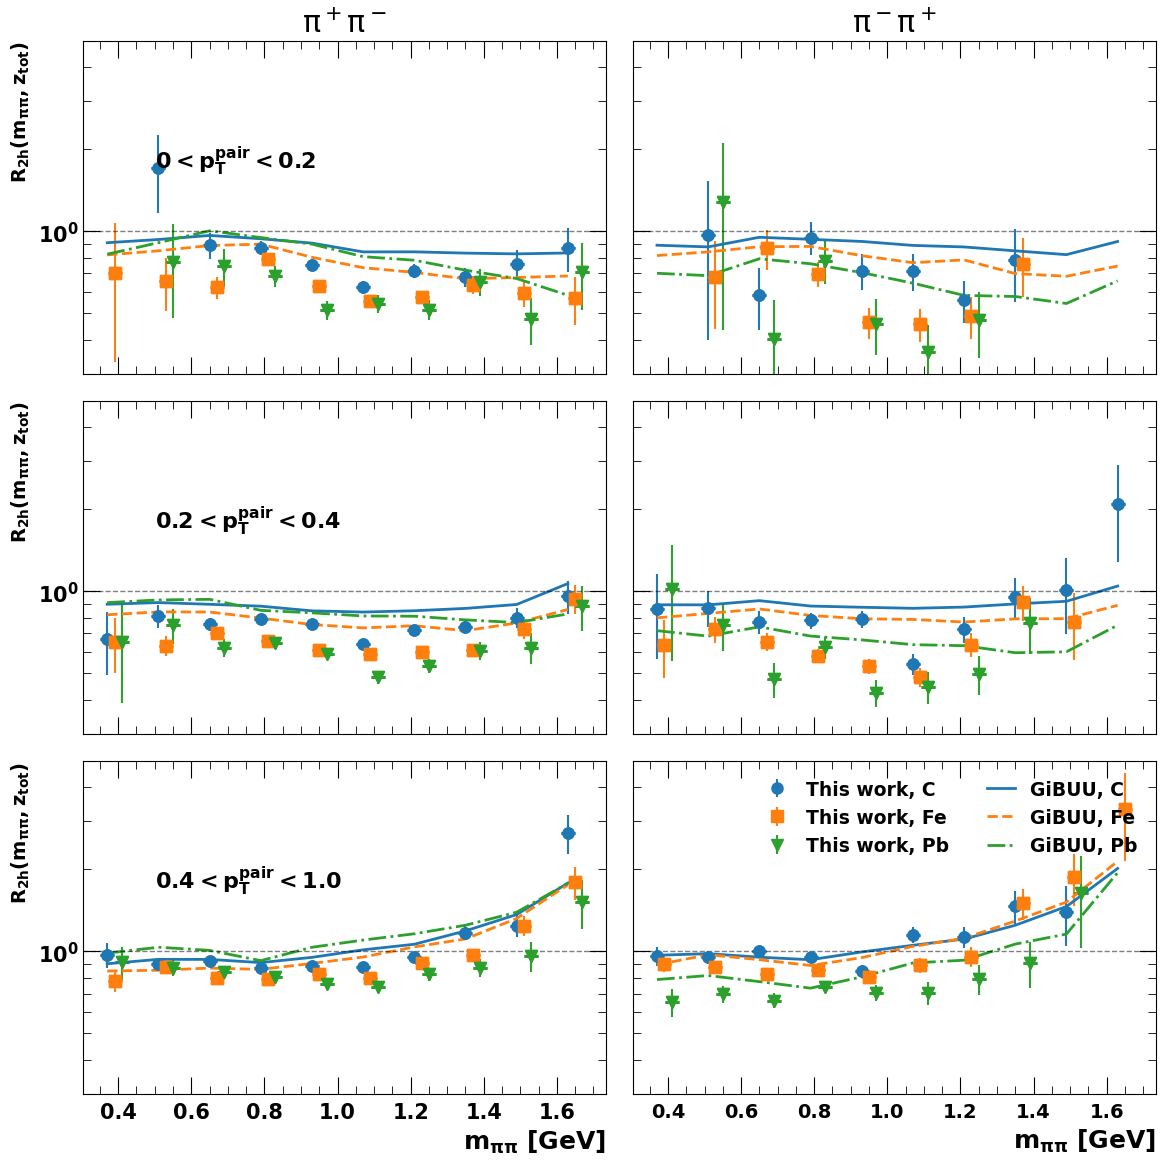

In [96]:
plt.show()

In [20]:
for key in df.keys():
    if not "GiBUU" in key:
        df[key].eval("theta1 = arcsin(h1_cm_pt/h2_p)*(2*(h1_rap+ycm>0)-1)+3.14159*(h1_rap+ycm<0)", inplace=True)
        df[key].eval("theta2 = arcsin(h2_cm_pt/h2_p)*(2*(h2_rap+ycm>0)-1)+3.14159*(h2_rap+ycm<0)", inplace=True)
        df[key].eval('dthetatot = arccos(cos(theta1)*cos(theta2)+sin(theta1)*sin(theta2)*cos(dphi))', inplace=True)

Print Trigger Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -1 ))  
Total Cut  h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h1_Nphe> (5*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) ) ) and h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(2.700000*2.700000) and h1_pid==211 ) +10000* (not 

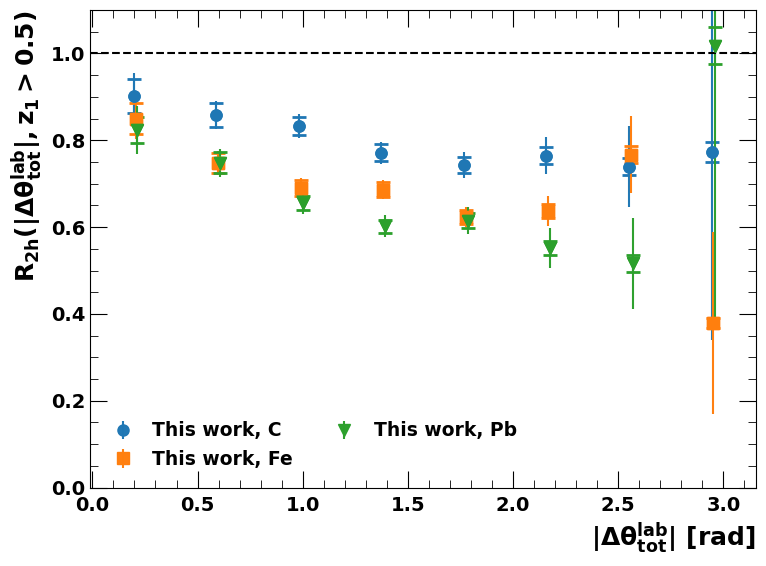

In [27]:


fig = plt.figure(figsize=(8,6))

dthetatotTable={}

artists=[]

colorBands=['black','#1f77b4','#ff7f0e','#2ca02c']
sysErr=sysErr_dphi

for j,target in enumerate(['C','Fe','Pb']):
    r, err,x = r2h.getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dthetatot', 
                            pair_cut = '%s and h2_z>0.05 and h2_z<0.45'%pair_cut_nom,
                            trig_cut = '%s'%trigger_cut_nom)
                            #pair_cut = 'and h2_z>0.1 and h2_z<0.5',
                            #trig_cut = 'h1_z>0.5' 
    dthetatotTable[target]={"r":r,"drstat":err,"drsys":sysErr[target],"min":mindphi,"max":maxdphi,"bins":dpiondphiBins}                     
    print('x is: ', x)
    print('r is: ', r) 
    print('err is: ', err) 
    print('sys err is:', sysErr[target]/100)
    stat=err
    syst=r*(sysErr[target]/100)
    tot=np.hypot(stat,syst)
    artists.append(plt.errorbar(np.subtract(x,-j*0.009),r,yerr=tot,label='This work, %s'%target,ms=8,fmt=symbols[target],
                 alpha=0.99,color=colors[target],)) #capsize=5, capthick=2)
    plt.errorbar(np.subtract(x,-j*0.009),r,yerr=syst,fmt=symbols[target],ms=8,capthick=2,capsize=5,color=colorBands[j+1])
    
    #plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
# for j,target in enumerate(['C','Fe','Pb']):   
#     #GiBUU
#     r, err,x = r2h.getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
#                         df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
#                         minz=mindphi,maxz=maxdphi,nbins=dpiondphiBins,variable='dthetatot', 
#                         pair_cut='and h2_z>0.05 and h2_z<0.45',
#                            trig_cut='h1_z>0.5')
#     artists.append(plt.plot(x,r,label='GiBUU, %s'%target,lw=2,color=colors[target], linestyle=linestyles[target])[0])
    
    
plt.xlabel('$|\Delta\\theta^{\\rm lab}_{\\rm tot}|$ [rad]',fontsize=18, fontweight='bold')
plt.ylabel('$\mathrm{R}_{\mathrm{2h}}(|\Delta\\theta^{\\rm lab}_{\\rm tot}|,\mathrm{z}_1>0.5)$',fontsize=18, fontweight='bold')
plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)

plt.xlim([-0.01,3.155])
plt.ylim([0,1.1])
#plt.ylim([0.55,0.73])
#plt.title('$0.10 < z_{2} < 0.50$')
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(artists, [artist.get_label() for artist in artists],loc='lower left',fontsize=13.5,ncol=2)
#plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
#plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()

#for paper
outname='dthetatot'
if not os.path.isdir(outdir):    os.mkdir(outdir)
plt.savefig(outdir+outname+'.pdf', bbox_inches='tight')
plt.savefig(outdir+outname+'.png', bbox_inches='tight')
plt.show()

